In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 1- Definition of a Lasso regression function

Three different versions are implemented
- Gradient descent Lasso
- ADMM Lasso
- ADMM Distributed Lasso

In [43]:
class LassoReg:
    def __init__(self, step_size, max_iterations, l1_penalty, tolerance):
        self.step_size = step_size
        self.max_iterations = max_iterations
        self.l1_penalty = l1_penalty
        self.tolerance = tolerance
        self.m = None
        self.n = None
        self.W = None
        self.X = None
        self.Y = None
        self.J = []  # Initialize J as an empty list
        self.iterations = None

    def fit(self, X, Y, algo, agents=None):
        self.m, self.n = X.shape
        self.W = np.zeros(self.n)
        self.X = X
        self.Y = Y

        if algo == "gd":
            self.gradient_descent()
        elif algo == "admm":
            self.admm_fit()
        elif algo == "distributed_admm":
            self.distributed_admm(agents)
        else:
            raise ValueError("Invalid algorithm")

    def gradient_descent(self):
        for i in range(1, self.max_iterations + 1):
            Y_predict = self.predict(self.X).flatten()

            soft_term = self.soft_threshold(self.W, self.l1_penalty)
            dW = (-2 * self.X.T @ (self.Y - Y_predict) + soft_term) / self.m
            
            new_W = self.W - self.step_size * dW
            
            if np.linalg.norm(new_W - self.W) < self.tolerance:
                break 

            self.J.append((np.linalg.norm(new_W - self.W),))
            self.W = new_W
            self.iterations = i

    def admm_fit(self):
        rho = self.step_size
        z = np.zeros(self.n)
        u = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100

        for i in range(1, self.max_iterations + 1):
            last_z = z

            self.W = np.linalg.solve(self.X.T @ self.X + rho * I, self.X.T @ self.Y + rho * (z - u))
            z = self.soft_threshold(self.W + u, self.l1_penalty / rho)
            u = u + self.W - z

            r_norm = np.linalg.norm(self.W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(self.W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * u)

            self.iterations = i
            self.J.append(np.array([r_norm, s_norm, tol_prim, tol_dual]))

            last_w = self.W.copy()
            norm_diff = np.linalg.norm(self.W - last_w) / np.linalg.norm(last_w)
            

            '''if (np.linalg.norm(s_norm) / rho < tol_dual and
                np.linalg.norm(r_norm) < tol_prim and
                norm_diff < abs_tol):
                break'''
            if r_norm < tol_prim and s_norm < tol_dual :
                break 

        self.W = self.W.reshape(1, -1)

    def distributed_admm(self, agents):
        rho = self.step_size
        z = np.zeros(self.n)
        I = np.eye(self.n)

        abs_tol = self.tolerance
        rel_tol = abs_tol * 100
        converged = False

        r, c = self.X.shape
        rows_per_agent = r // agents
        total_rows_used = rows_per_agent * agents

        #print(f"Total rows used: {total_rows_used}")
        #print(f"Rows per agent: {rows_per_agent}")

        splitted_X = self.X[:total_rows_used, :].reshape((rows_per_agent, agents, c))
        splitted_Y = np.reshape(self.Y[:total_rows_used], (rows_per_agent, agents))
        self.W = np.zeros((agents, c))
        u = np.zeros((agents, c))

        for i in range(1, self.max_iterations + 1):
            last_z = z
            for j in range(agents):
                self.W[j, :] = np.linalg.solve(splitted_X[:, j, :].T @ splitted_X[:, j, :] + (rho / 2) * I, splitted_X[:, j, :].T @ splitted_Y[:, j] + (rho / 2) * (z - u[j, :]))
            
            # Fusion center aggregates information from agents
            global_W = np.mean(self.W, axis=0)
            global_u = np.mean(u, axis=0)

            # Fusion center updates z based on aggregated information
            z = self.soft_threshold(global_W + global_u, self.l1_penalty / (rho * agents))

            # Distribute updated information to agents
            for j in range(agents):
                u[j, :] = u[j, :] + (self.W[j, :] - z)
                
            global_u = np.mean(u, axis=0)    

            r_norm = np.linalg.norm(global_W - z)  # primary residual
            s_norm = np.linalg.norm(-rho * (z - last_z))  # dual residual
            tol_prim = np.sqrt(self.n) * abs_tol + rel_tol * max(np.linalg.norm(global_W), np.linalg.norm(-z))
            tol_dual = np.sqrt(self.n) * abs_tol + rel_tol * np.linalg.norm(rho * global_u)

            self.iterations = i
            self.J.append((r_norm, s_norm, tol_prim, tol_dual))

            last_w = self.W.copy()
            norm_diff = np.linalg.norm(self.W - last_w) / np.linalg.norm(last_w)
            
            '''if (np.linalg.norm(s_norm) / rho < tol_dual and
                np.linalg.norm(r_norm) < tol_prim and
                norm_diff < abs_tol):
                break'''

            if r_norm < tol_prim and s_norm < tol_dual:
                converged = True
                break

        self.W = global_W.reshape(1, -1)

    def predict(self, X):
        return X @ self.W.T.flatten()

    def loss_function(self, Y, Y_predict, W):
        return 0.5 * np.sum((Y - Y_predict) ** 2) + self.l1_penalty * np.linalg.norm(W, 1)

    def soft_threshold(self, w, th):
        return np.maximum(0, w - th) - np.maximum(0, -w - th)

    def mean_squared_error(self, Y_true, Y_predicted):
        return np.mean((Y_true - Y_predicted) ** 2)

## 1.2- Definition of plot functions

In [44]:
def prediction_plot(Y_test, Y_pred, title):
    plt.scatter(Y_test, Y_pred, color='brown', label='Predicted vs. Measured')
    plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4, label='Ideal')
    plt.xlabel('Measured')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

def loss_plot(J, title):
    plt.plot(J, color='brown', label='Total Loss')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.show()

def loss_plot_admm(J, title):
    r_loss = [row[0] for row in J]  
    s_loss = [row[1] for row in J]  

    plt.plot(r_loss, label='Primary Residual', color='purple')
    plt.plot(s_loss, label='Dual Residual', color='green')
    plt.legend()
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.title(title)
    plt.show()

In [45]:
def loss_plot_admm_val(ax, loss_data, title):
    ax.plot(np.arange(1, len(loss_data) + 1), np.array(loss_data)[:, 0], label='Primal Residual', color = 'purple')
    ax.plot(np.arange(1, len(loss_data) + 1), np.array(loss_data)[:, 1], label='Dual Residual', color = 'green')
    ax.set_xlabel('Iterazioni')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()    

def loss_plot_distributed_admm_val(ax, lasso_model, title):
    r_loss = [row[0] for row in lasso_model.J]
    s_loss = [row[1] for row in lasso_model.J]

    ax.plot(np.arange(1, len(lasso_model.J) + 1), r_loss, label='Primary Residual', color='purple')
    ax.plot(np.arange(1, len(lasso_model.J) + 1), s_loss, label='Dual Residual', color='green')

    ax.set_xlabel('Iterazioni')
    ax.set_ylabel('Loss')
    ax.set_title(title)
    ax.legend()

# 2- Test on first synthetically generated dataset

## 2.1- Dataset generation

A simple dataset is generated to test the functioning of the 3 versions of Lasso

In [46]:
n_features = 3

X_num = np.random.rand(300, n_features)
X_cat = np.random.randint(0, 2, (300, 1))
X_cat_one_hot = pd.get_dummies(X_cat.flatten(), prefix='cat', drop_first=True).values
X = np.concatenate((X_num, X_cat_one_hot), axis=1)

y = 2 * X[:, 0] + X[:, 1] + 0.1 * np.random.randn(300)

In [47]:
print(X.shape)

X_dataframe = pd.DataFrame(X, columns=["X1", "X2", "X3", "cat_0"])
print(X_dataframe.head())

(300, 4)
         X1        X2        X3  cat_0
0  0.221384  0.246223  0.791321    0.0
1  0.192768  0.157594  0.320504    0.0
2  0.680385  0.206785  0.991633    1.0
3  0.902442  0.507231  0.199853    1.0
4  0.757722  0.353594  0.054887    0.0


In [48]:
y_dataframe = pd.DataFrame(y, columns=["Y"])
print(y_dataframe.head())

          Y
0  0.560144
1  0.577856
2  1.518198
3  2.278571
4  2.058604


Visualize distribution of data

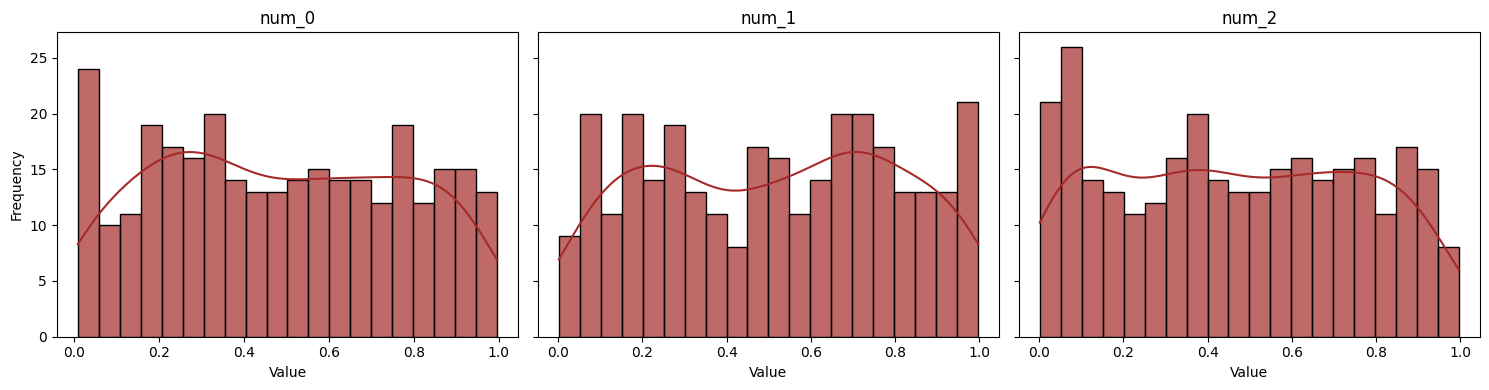

In [49]:
fig, axes = plt.subplots(1, n_features, figsize=(15, 4), sharey=True)

for i in range(n_features):
    sns.histplot(X[:, i], bins=20, kde=True, ax=axes[i], color='brown', alpha=0.7)
    axes[i].set_title(f'num_{i}')
    axes[i].set_xlabel('Value')

axes[0].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

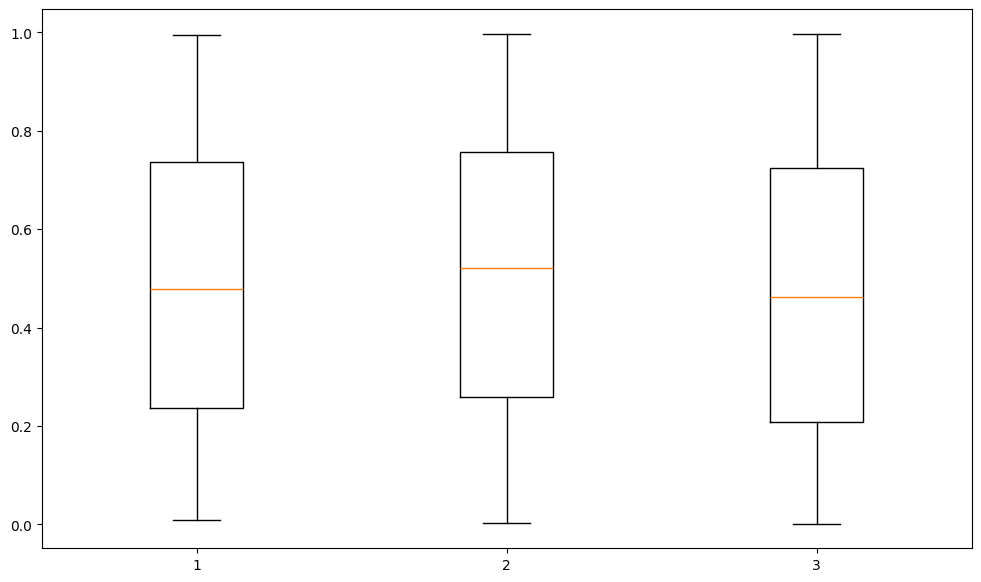

In [50]:
plt.figure(figsize=(12, 7))
plt.boxplot(X_num)
plt.show()

Visualize the distribution of target variable

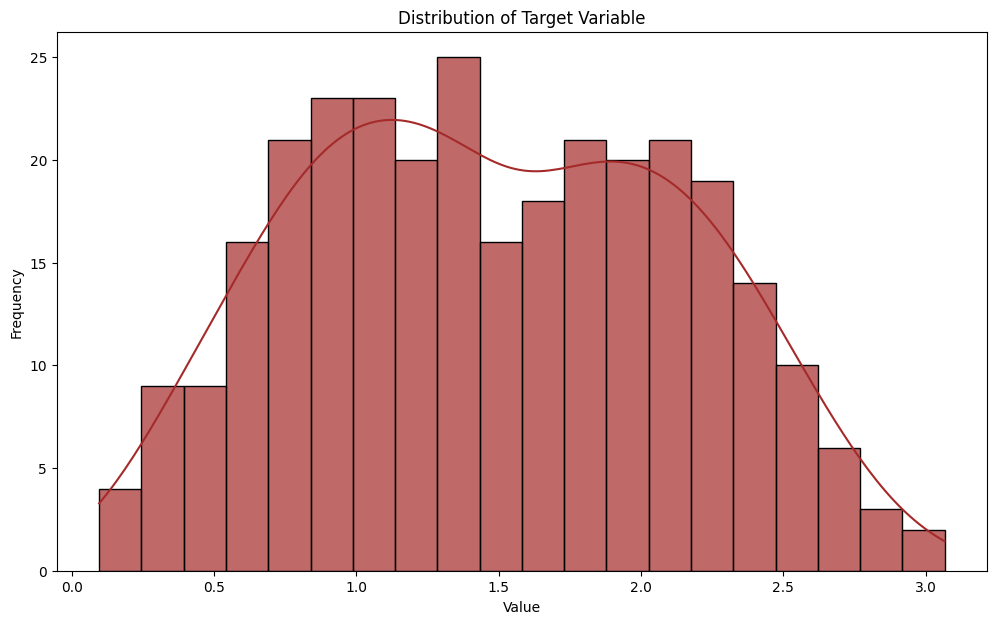

In [51]:
plt.figure(figsize=(12, 7))
sns.histplot(y, bins=20, kde=True, color='brown', alpha=0.7)
plt.title('Distribution of Target Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Division of the dataset into train set and test set

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Data normalisation

In [53]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [54]:
# parameters
step_size = 0.01
l1_penalty = 0.1
max_iterations = 100000
tolerance = 1e-3

## 2.2- Training and testing the model on the dataset evaluating the impact of the choice of parameters

### 2.2.1- Lasso Gradient Descent

Validation of step_size parameter

In [55]:
step_sizes = [0.001, 0.01, 0.1, 0.5]

for step_size in step_sizes:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train, y_train, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with step_size {step_size}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with step_size {step_size}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test)

    r2 = r2_score(y_test, y_pred_gd)
    print(f"R^2 with step_size {step_size}: {r2}")

GD time with step_size 0.001: 0.11656498908996582
GD iterations with step_size 0.001: 555
R^2 with step_size 0.001: -0.18109280057102306
GD time with step_size 0.01: 0.04926300048828125
GD iterations with step_size 0.01: 553
R^2 with step_size 0.01: 0.8711568729313993
GD time with step_size 0.1: 0.01583242416381836
GD iterations with step_size 0.1: 191
R^2 with step_size 0.1: 0.9722994859036488
GD time with step_size 0.5: 0.0029442310333251953
GD iterations with step_size 0.5: 56
R^2 with step_size 0.5: 0.9751924041669274


Validation of l1_penalty parameter

In [56]:
step_size = 0.5
l1_penalties = [0.01, 0.1, 1, 10]

for l1_penalty in l1_penalties:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train, y_train, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with l1_penalty {l1_penalty}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with l1_penalty {l1_penalty}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test)

    r2 = r2_score(y_test, y_pred_gd)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

GD time with l1_penalty 0.01: 0.00391077995300293
GD iterations with l1_penalty 0.01: 56
R^2 with l1_penalty 0.01: 0.9751804219434609
GD time with l1_penalty 0.1: 0.004014492034912109
GD iterations with l1_penalty 0.1: 56
R^2 with l1_penalty 0.1: 0.9751924041669274
GD time with l1_penalty 1: 0.0048520565032958984
GD iterations with l1_penalty 1: 57
R^2 with l1_penalty 1: 0.9759374863767032
GD time with l1_penalty 10: 0.003996849060058594
GD iterations with l1_penalty 10: 58
R^2 with l1_penalty 10: 0.9763157899014997


### 2.2.2- Lasso ADMM

Validation of step_size parameter

ADMM time with step_size 0.001: 0.04355978965759277
ADMM iterations with step_size 0.001: 104
R^2 with step_size 0.001: 0.976510884429569
ADMM time with step_size 0.01: 0.006032466888427734
ADMM iterations with step_size 0.01: 12
R^2 with step_size 0.01: 0.9765105245719018
ADMM time with step_size 0.1: 0.000995635986328125
ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.9765215339747558
ADMM time with step_size 0.5: 0.0010094642639160156
ADMM iterations with step_size 0.5: 3
R^2 with step_size 0.5: 0.9766036450879166


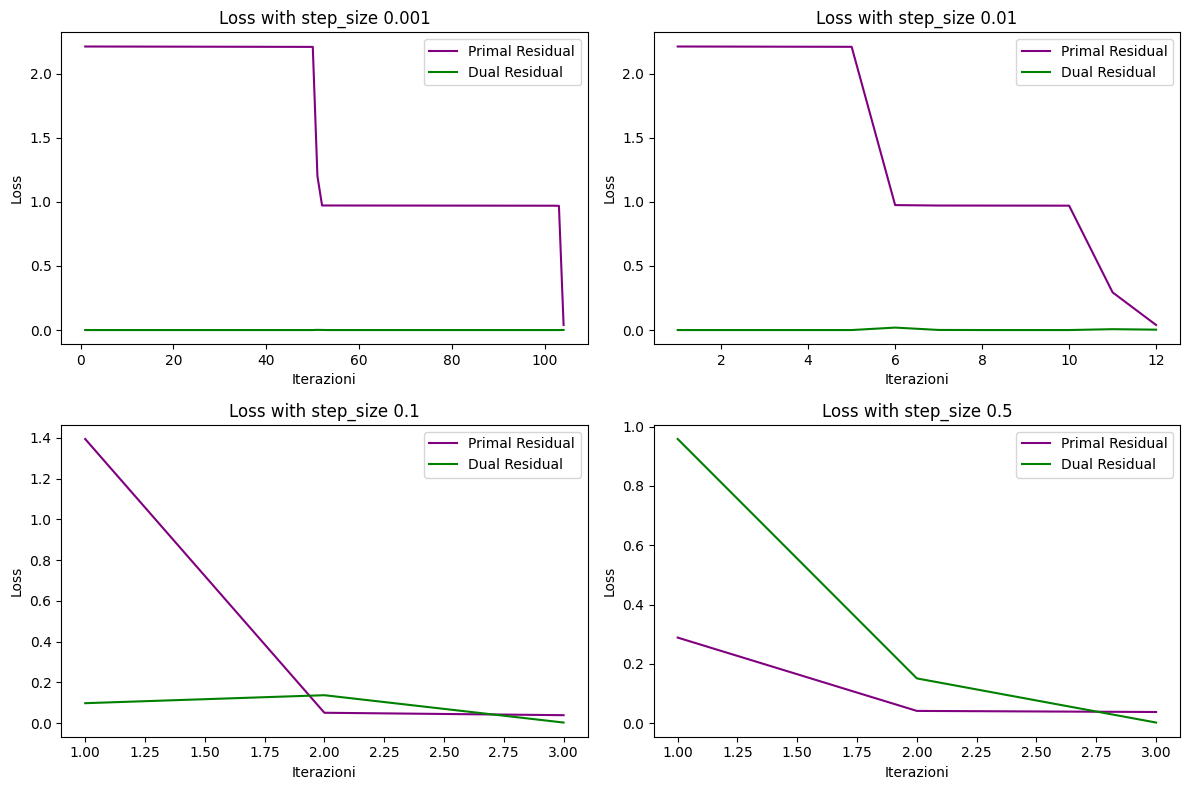

In [86]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

step_sizes = [0.001, 0.01, 0.1, 0.5]
l1_penalty = 0.1

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train, y_train, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with step_size {step_size}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with step_size {step_size}: {iterations_admm}")

    y_pred_admm = lasso_admm.predict(X_test)

    r2 = 1 - np.mean((y_test - y_pred_admm) ** 2) / np.var(y_test)
    print(f"R^2 with step_size {step_size}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

ADMM time with l1_penalty 0.01: 0.0009467601776123047
ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.9766055475709422
ADMM time with l1_penalty 0.1: 0.0016226768493652344
ADMM iterations with l1_penalty 0.1: 3
R^2 with l1_penalty 0.1: 0.9766036450879166
ADMM time with l1_penalty 1: 0.0009999275207519531
ADMM iterations with l1_penalty 1: 4
R^2 with l1_penalty 1: 0.9753559292612239
ADMM time with l1_penalty 10: 0.03577852249145508
ADMM iterations with l1_penalty 10: 42
R^2 with l1_penalty 10: 0.9421570956622922


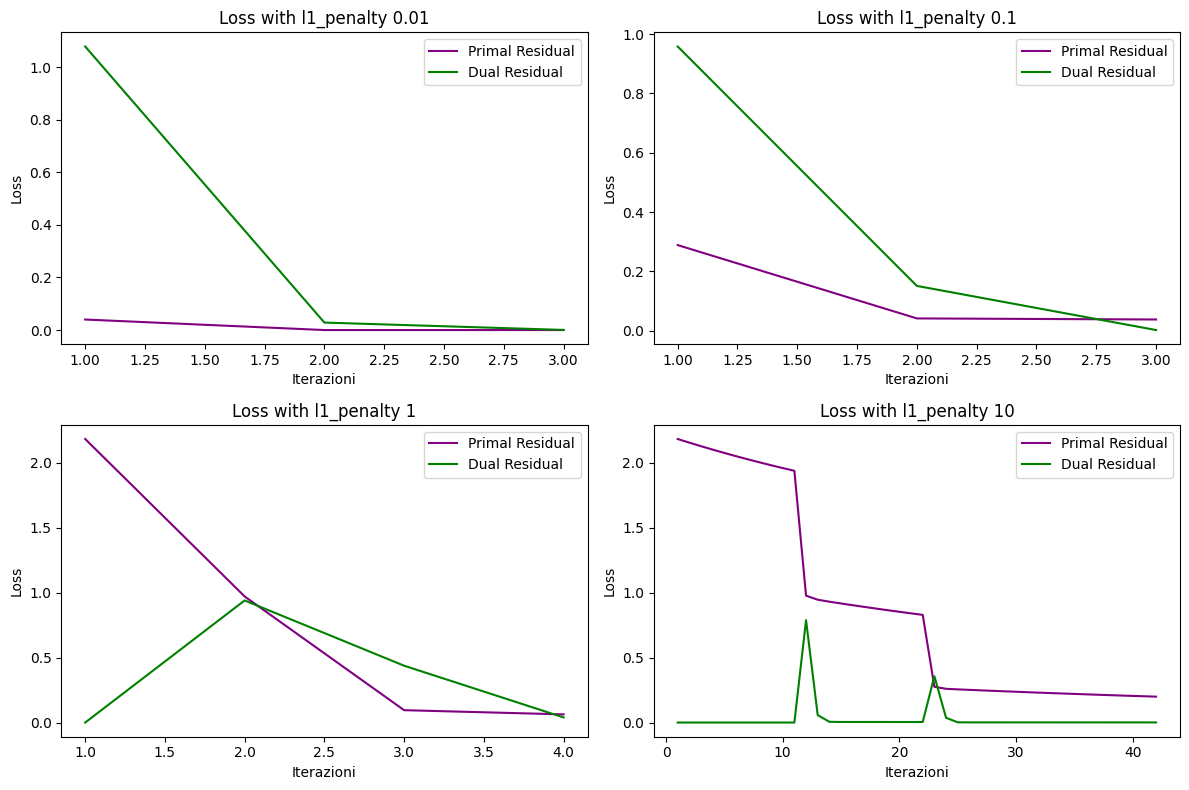

In [87]:
step_size = 0.5
l1_penalties = [0.01, 0.1, 1, 10]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()
    
    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train, y_train, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with l1_penalty {l1_penalty}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with l1_penalty {l1_penalty}: {iterations_admm}")
    
    y_pred_admm = lasso_admm.predict(X_test)

    r2 = r2_score(y_test, y_pred_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()

plt.show()    

### 2.2.3- Lasso Distributed ADMM

Validation of step_size parameter

Distributed ADMM time with step_size 0.001: 0.015998363494873047
Distributed ADMM iterations with step_size 0.001: 36
R^2 with step_size 0.001: 0.9765504102138425
Distributed ADMM time with step_size 0.01: 0.000993967056274414
Distributed ADMM iterations with step_size 0.01: 5
R^2 with step_size 0.01: 0.9765475923245704
Distributed ADMM time with step_size 0.1: 0.0019960403442382812
Distributed ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.9765734463240092
Distributed ADMM time with step_size 0.5: 0.001999378204345703
Distributed ADMM iterations with step_size 0.5: 3
R^2 with step_size 0.5: 0.976631020720669


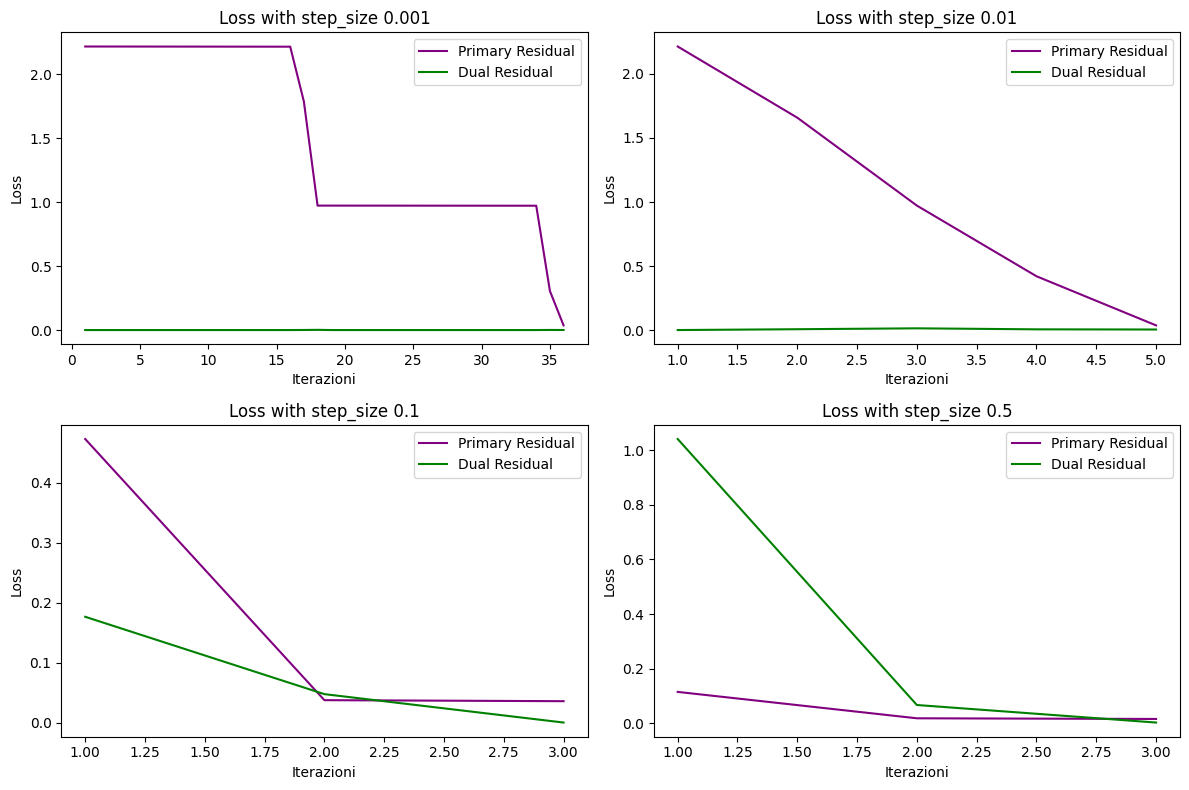

In [88]:
step_sizes = [0.001, 0.01, 0.1, 0.5]
l1_penalty = 0.1
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train, y_train, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with step_size {step_size}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with step_size {step_size}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test)

    r2 = r2_score(y_test, y_pred_distributed_admm)
    print(f"R^2 with step_size {step_size}: {r2}")
    
    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with step_size {step_size}')

plt.tight_layout()
plt.show()

Validation of l1_penalty parameter

Distributed ADMM time with l1_penalty 0.01: 0.0018825531005859375
Distributed ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.976594989137665
Distributed ADMM time with l1_penalty 0.1: 0.001995086669921875
Distributed ADMM iterations with l1_penalty 0.1: 3
R^2 with l1_penalty 0.1: 0.976631020720669
Distributed ADMM time with l1_penalty 1: 0.0020017623901367188
Distributed ADMM iterations with l1_penalty 1: 3
R^2 with l1_penalty 1: 0.976240068659101
Distributed ADMM time with l1_penalty 10: 0.006704568862915039
Distributed ADMM iterations with l1_penalty 10: 8
R^2 with l1_penalty 10: 0.9586018933330015


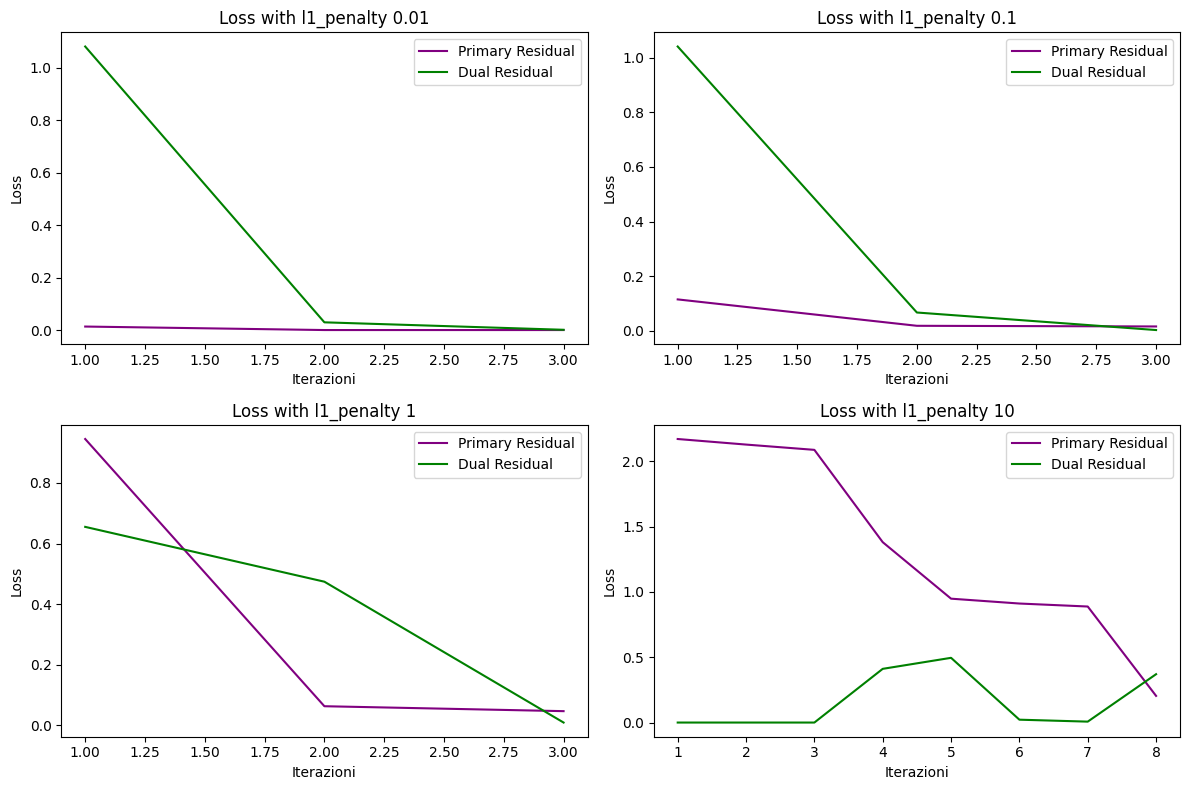

In [89]:
l1_penalties = [0.01, 0.1, 1, 10]
step_size = 0.5
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train, y_train, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with l1_penalty {l1_penalty}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with l1_penalty {l1_penalty}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test)

    r2 = r2_score(y_test, y_pred_distributed_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()
plt.show()

Validation of num_agents parameter

Distributed ADMM time with 3 agents: 0.0016405582427978516
Distributed ADMM iterations with 3 agents: 3
R^2 with 3 agents: 0.976631020720669
Distributed ADMM time with 5 agents: 0.0019464492797851562
Distributed ADMM iterations with 5 agents: 3
R^2 with 5 agents: 0.9763066570406652
Distributed ADMM time with 10 agents: 0.0029990673065185547
Distributed ADMM iterations with 10 agents: 4
R^2 with 10 agents: 0.976625662813346
Distributed ADMM time with 20 agents: 0.004992008209228516
Distributed ADMM iterations with 20 agents: 5
R^2 with 20 agents: 0.9770325043018635


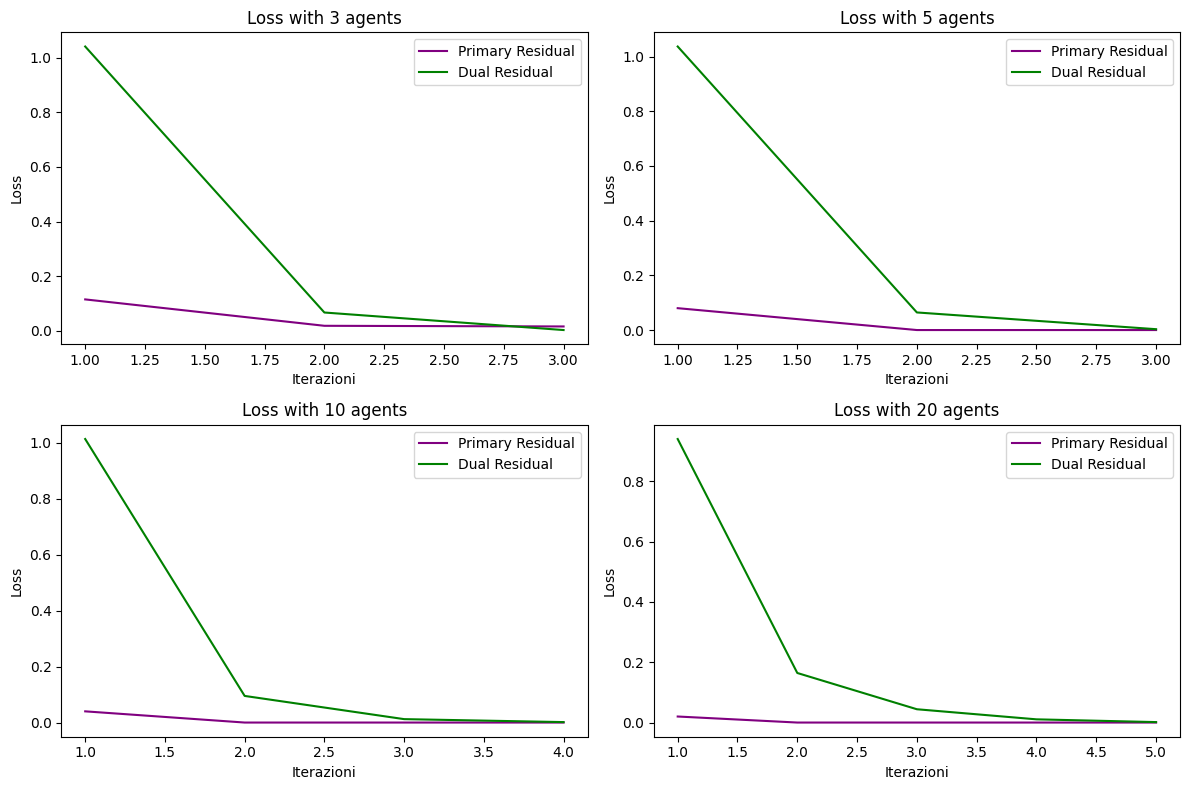

In [92]:
agents = [3, 5, 10, 20]
step_size = 0.5
l1_penalty = 0.1

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, agent in enumerate(agents, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train, y_train, algo="distributed_admm", agents=agent)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with {agent} agents: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with {agent} agents: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test)

    r2 = r2_score(y_test, y_pred_distributed_admm)
    print(f"R^2 with {agent} agents: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with {agent} agents')

plt.tight_layout()
plt.show()

### 2.2.4 Comparison of Lasso versions

Gradient Descent

GD time: 0.007096767425537109
GD iterations: 58
R^2: 0.9763157899014997
MSE: 0.010295856612341848
MAE: 0.07560689753295208


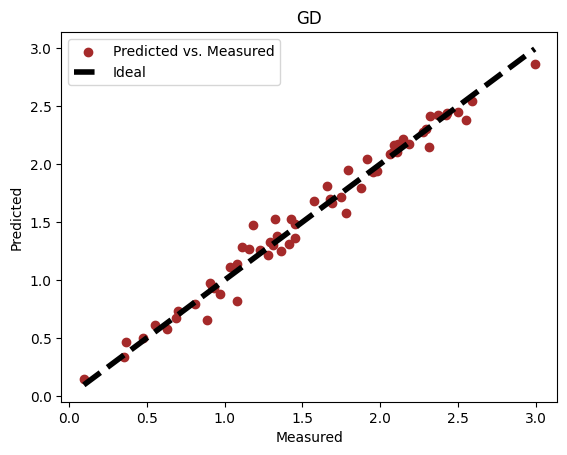

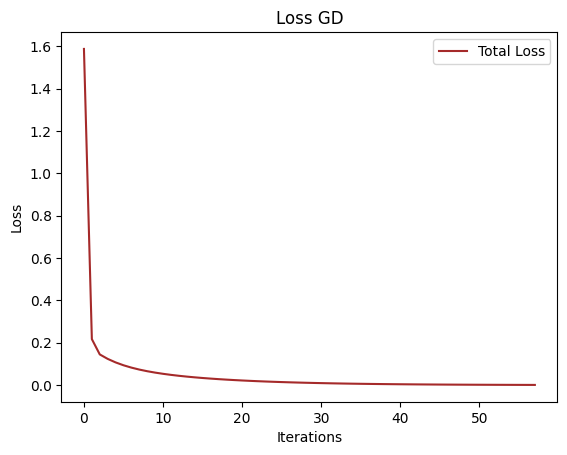

In [93]:
# parameters
step_size = 0.5
l1_penalty = 10

# GD
start_time = time.time()
lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_gd.fit(X_train, y_train, algo="gd")
gd_time = time.time() - start_time
print(f"GD time: {gd_time}")

iterations_gd = lasso_gd.iterations
print(f"GD iterations: {iterations_gd}")

y_pred_gd = lasso_gd.predict(X_test)

# metrics
r2_gd = r2_score(y_test, y_pred_gd)
print(f"R^2: {r2_gd}")

mse_gd = mean_squared_error(y_test, y_pred_gd)
print(f"MSE: {mse_gd}")
mae_gd = mean_absolute_error(y_test, y_pred_gd)
print(f"MAE: {mae_gd}")

# plots
prediction_plot(y_test, y_pred_gd, "GD")
loss_plot(lasso_gd.J, "Loss GD")

ADMM

ADMM time: 0.001209259033203125
ADMM iterations: 3
R^2: 0.9766036450879166
MSE: 0.010170721946159514
MAE: 0.0751356730172381


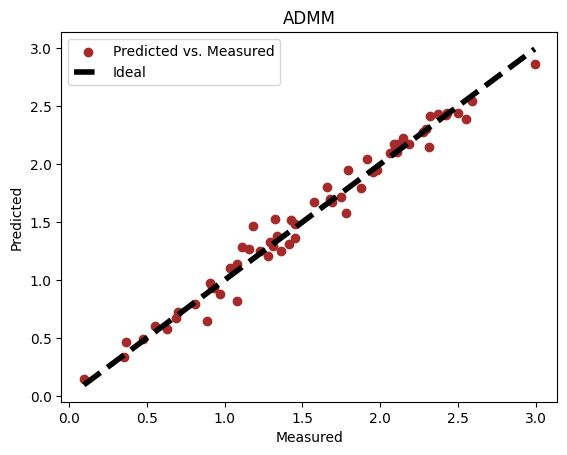

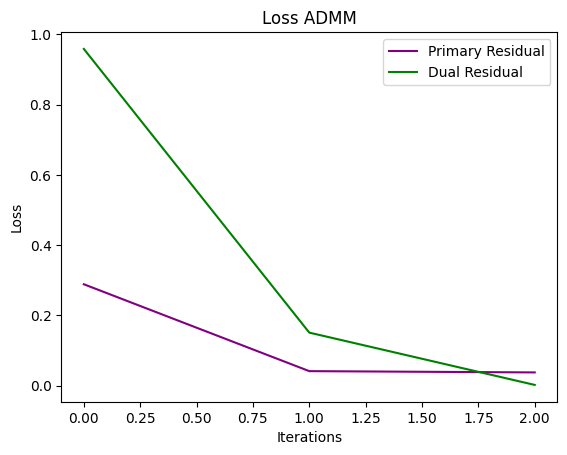

In [94]:
# parameters
step_size = 0.5
l1_penalty = 0.1

# ADMM
start_time = time.time()
lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train, y_train, algo="admm")
admm_time = time.time() - start_time
print(f"ADMM time: {admm_time}")

iterations_admm = lasso_admm.iterations
print(f"ADMM iterations: {iterations_admm}")

y_pred_admm = lasso_admm.predict(X_test)

# metrics
r2_admm = r2_score(y_test, y_pred_admm)
print(f"R^2: {r2_admm}")

mse_admm = mean_squared_error(y_test, y_pred_admm)
print(f"MSE: {mse_admm}")
mae_admm = mean_absolute_error(y_test, y_pred_admm)
print(f"MAE: {mae_admm}")

# plots
prediction_plot(y_test, y_pred_admm, "ADMM")
loss_plot_admm(lasso_admm.J, "Loss ADMM")

Distributed ADMM

Distributed ADMM time: 0.011339902877807617
Distributed ADMM iterations: 5
R^2: 0.9770325043018635
MSE: 0.009984290861681072
MAE: 0.07504139731157883


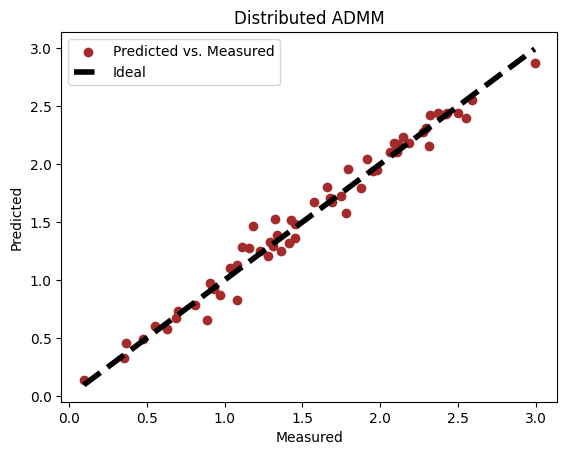

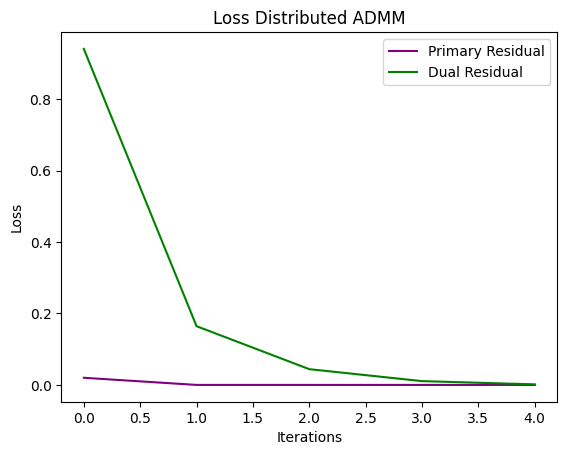

In [95]:
# parameters
step_size = 0.5
l1_penalty = 0.1
agents = 20

# Distributed ADMM
start_time = time.time()
lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_distributed_admm.fit(X_train, y_train, algo="distributed_admm", agents=agents)
distributed_admm_time = time.time() - start_time
print(f"Distributed ADMM time: {distributed_admm_time}")

iterations_distributed_admm = lasso_distributed_admm.iterations
print(f"Distributed ADMM iterations: {iterations_distributed_admm}")

y_pred_distributed_admm = lasso_distributed_admm.predict(X_test)

# metrics
r2_distributed_admm = r2_score(y_test, y_pred_distributed_admm)
print(f"R^2: {r2_distributed_admm}")

mse_distributed_admm = mean_squared_error(y_test, y_pred_distributed_admm)
print(f"MSE: {mse_distributed_admm}")
mae_distributed_admm = mean_absolute_error(y_test, y_pred_distributed_admm)
print(f"MAE: {mae_distributed_admm}")

# plots
prediction_plot(y_test, y_pred_distributed_admm, "Distributed ADMM")
loss_plot_admm(lasso_distributed_admm.J, "Loss Distributed ADMM")

# 3- Test on second synthetically generated dataset

## 3.1- Dataset generation

A second, more complex dataset is generated

In [65]:
n_num_features = 8
n_cat_features = 2
n_samples = 2000

X_numeric = np.column_stack((
    np.random.normal(loc=7, scale=2, size=(n_samples, 1)),  
    np.random.uniform(low=2, high=12, size=(n_samples, 1)),  
    np.random.exponential(scale=3, size=(n_samples, 1)),  
    np.random.poisson(lam=4, size=(n_samples, 1)),  
    np.random.gamma(shape=3, scale=2, size=(n_samples, 1)),  
    np.random.logistic(loc=-2, scale=1, size=(n_samples, 1)),  
    np.random.chisquare(df=3, size=(n_samples, 1)),  
    np.random.power(a=4, size=(n_samples, 1))                                       
))

X_categorical = np.random.choice([1, 2, 3, 4], size=(n_samples, n_cat_features))

X = np.concatenate((X_numeric, X_categorical), axis=1)

In [66]:
true_weights_numeric = np.random.uniform(-10, 10, n_num_features)

true_weights_categorical = np.random.uniform(-2, 2, n_cat_features)

y = (X_numeric @ true_weights_numeric  + X_categorical @ true_weights_categorical  + 14 + 17 * np.random.randn(n_samples) + np.sin(0.15 * X_numeric[:, 0]) + np.exp(0.2 * X_numeric[:, 1]) + np.cos(0.3 * X_numeric[:, 2]) * X_categorical[:, 0] + np.tanh(0.25 * X_numeric[:, 4]) * X_categorical[:, 1] + 0.25 * np.random.uniform(-10, 71, n_samples))

Visualize distribution of data

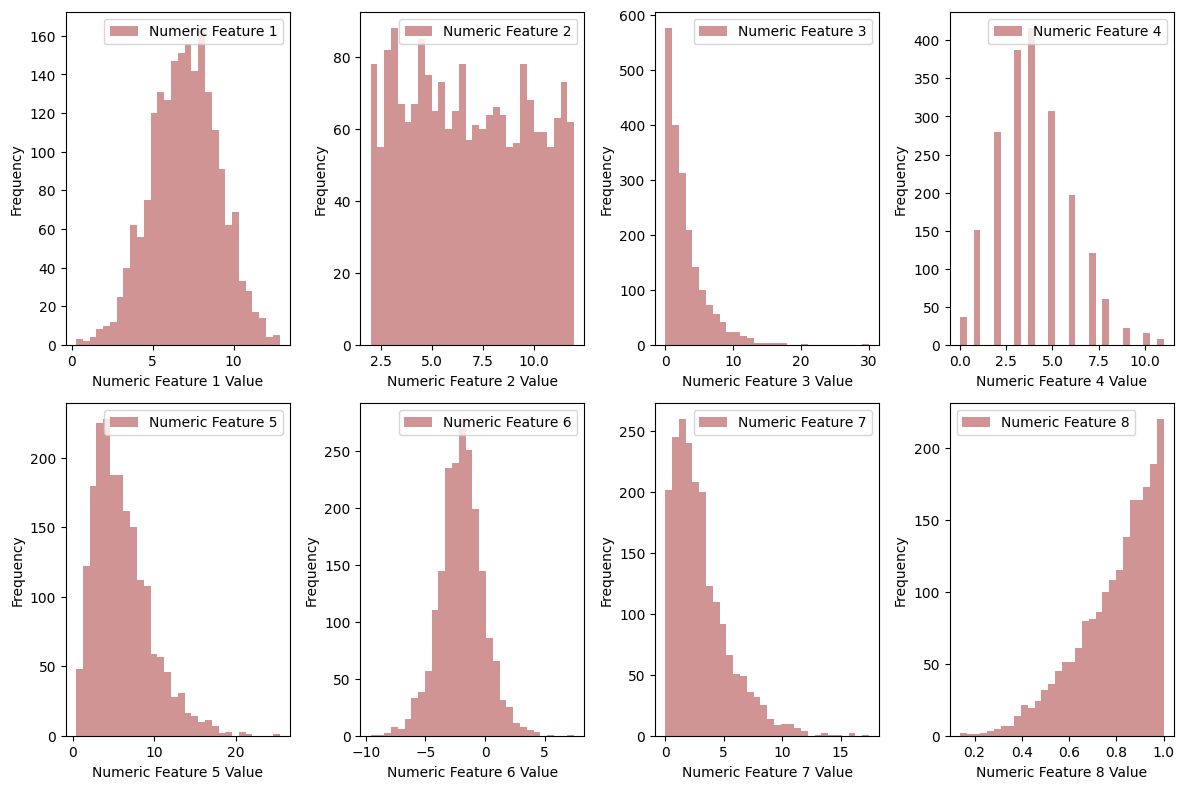

In [67]:
fig, axes = plt.subplots(nrows=2, ncols=n_num_features // 2, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.hist(X_numeric[:, i], bins=30, alpha=0.5, label=f'Numeric Feature {i + 1}', color='brown')
    ax.legend()
    ax.set_xlabel(f'Numeric Feature {i + 1} Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

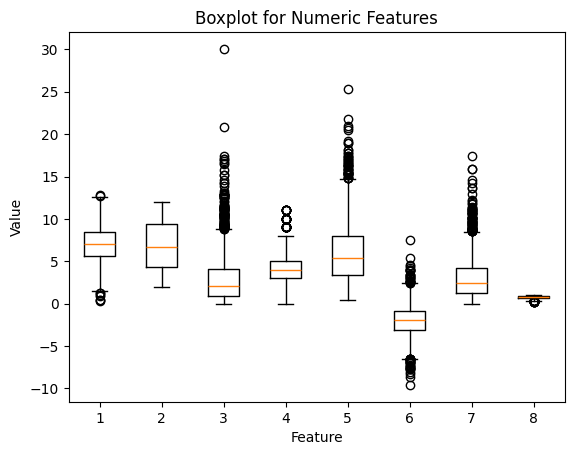

In [68]:
plt.boxplot(X_numeric)
plt.xlabel('Feature')
plt.ylabel('Value')
plt.title('Boxplot for Numeric Features')
plt.show()

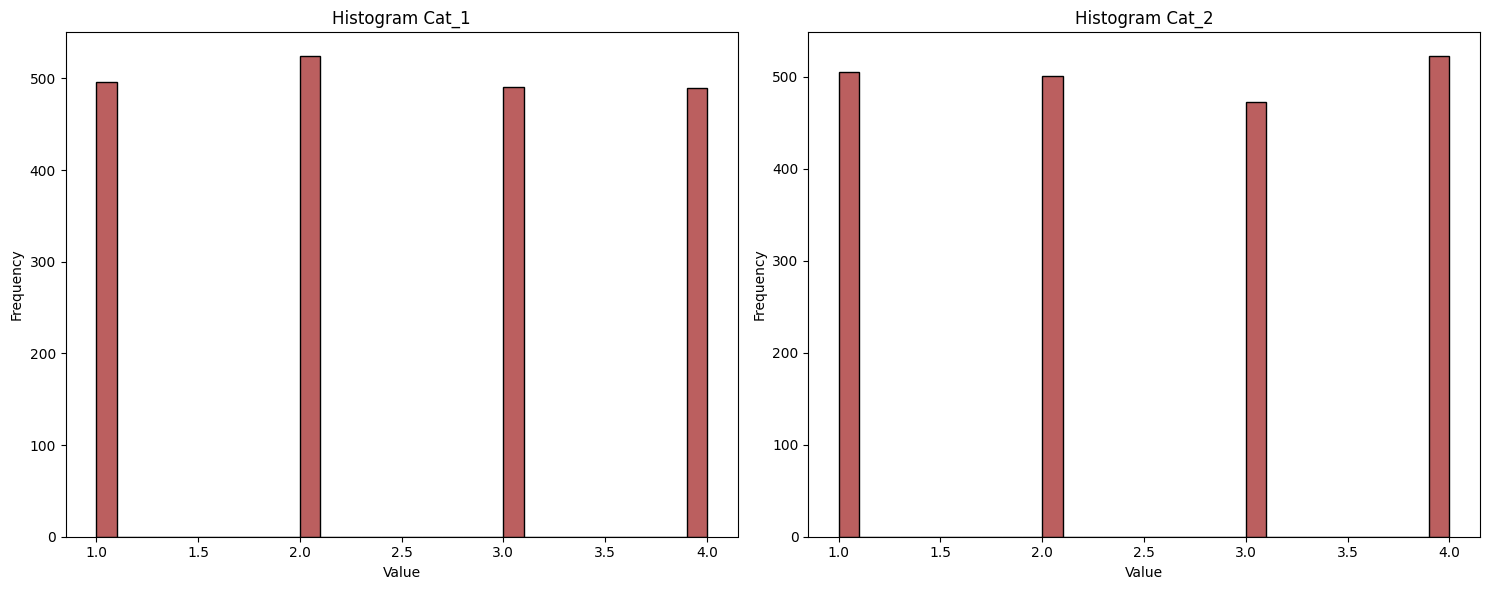

In [69]:
df_cat = pd.DataFrame(X_categorical, columns=[f'Cat_{i + 1}' for i in range(n_cat_features)])

plt.figure(figsize=(15, 6))
for i in range(n_cat_features):
    plt.subplot(1, n_cat_features, i + 1)
    sns.histplot(df_cat[f'Cat_{i + 1}'], bins=30, color='brown', edgecolor='black')
    plt.title(f'Histogram Cat_{i + 1}')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

Visualize distribution of target variable

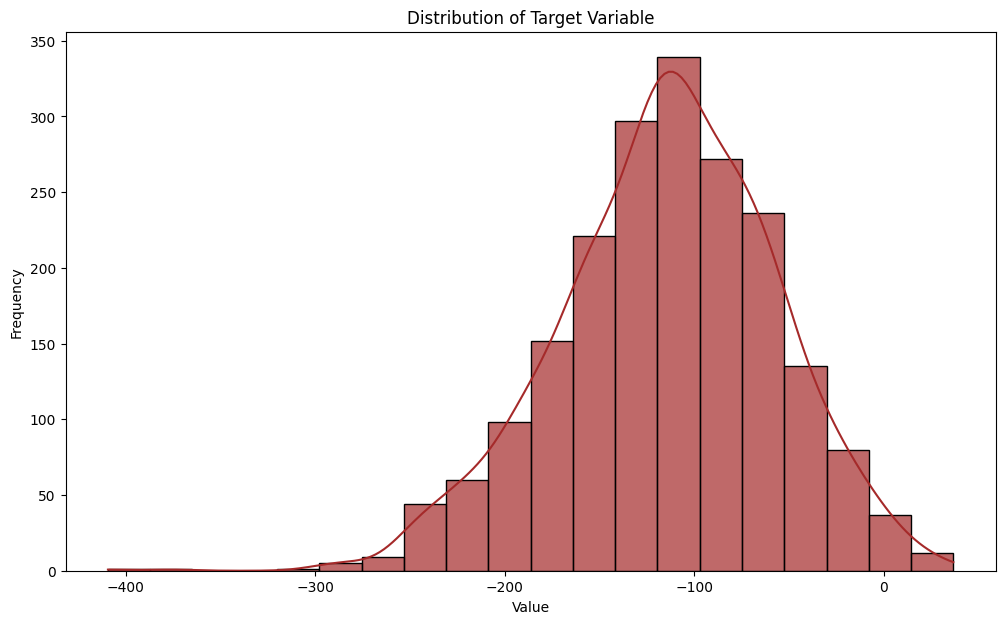

In [70]:
plt.figure(figsize=(12, 7))
sns.histplot(y, bins=20, kde=True, color='brown', alpha=0.7)
plt.title('Distribution of Target Variable')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [71]:
X_one_hot = pd.get_dummies(df_cat, columns=df_cat.columns, drop_first=True).values

X = np.concatenate((X_numeric, X_one_hot), axis=1)

Division of the dataset into train set and test set

In [72]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)

Data normalisation

In [73]:
scaler = MinMaxScaler()
X_train_2 = scaler.fit_transform(X_train_2)
X_test_2 = scaler.transform(X_test_2)

In [74]:
# parameters
step_size = 0.01
l1_penalty = 0.1
max_iterations = 100000
tolerance = 1e-3

## 3.2- Training and testing the model on the dataset evaluating the impact of the choice of parameters

### 3.2.1- Lasso Gradient Descent

Validation of step_size parameter

In [96]:
step_sizes = [0.001, 0.01, 0.1, 0.5]

for step_size in step_sizes:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train_2, y_train_2, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with step_size {step_size}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with step_size {step_size}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_gd)
    print(f"R^2 with step_size {step_size}: {r2}")


GD time with step_size 0.001: 53.9903347492218
GD iterations with step_size 0.001: 56738
R^2 with step_size 0.001: 0.8898961648204455
GD time with step_size 0.01: 10.414574384689331
GD iterations with step_size 0.01: 11193
R^2 with step_size 0.01: 0.8955597764647554
GD time with step_size 0.1: 1.736992597579956
GD iterations with step_size 0.1: 1692
R^2 with step_size 0.1: 0.8957925377631626
GD time with step_size 0.5: 0.2230234146118164
GD iterations with step_size 0.5: 418
R^2 with step_size 0.5: 0.8958116951135282


Validation of l1_penalty parameter

In [98]:
step_size = 0.5
l1_penalties = [0.01, 0.1, 1, 10]

for l1_penalty in l1_penalties:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train_2, y_train_2, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with l1_penalty {l1_penalty}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with l1_penalty {l1_penalty}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_gd)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

GD time with l1_penalty 0.01: 0.2929389476776123
GD iterations with l1_penalty 0.01: 418
R^2 with l1_penalty 0.01: 0.8958121102865138
GD time with l1_penalty 0.1: 0.28745436668395996
GD iterations with l1_penalty 0.1: 418
R^2 with l1_penalty 0.1: 0.8958116951135282
GD time with l1_penalty 1: 0.4588346481323242
GD iterations with l1_penalty 1: 418
R^2 with l1_penalty 1: 0.8958076420645609
GD time with l1_penalty 10: 0.4862029552459717
GD iterations with l1_penalty 10: 418
R^2 with l1_penalty 10: 0.8957802174306754


### 3.2.2- Lasso ADMM

Validation of step_size parameter

ADMM time with step_size 0.001: 0.004003763198852539
ADMM iterations with step_size 0.001: 4
R^2 with step_size 0.001: 0.8959929327302301
ADMM time with step_size 0.01: 0.0030181407928466797
ADMM iterations with step_size 0.01: 4
R^2 with step_size 0.01: 0.895993382351441
ADMM time with step_size 0.1: 0.003006458282470703
ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.895993401210701
ADMM time with step_size 0.5: 0.002584218978881836
ADMM iterations with step_size 0.5: 3
R^2 with step_size 0.5: 0.895993391044466


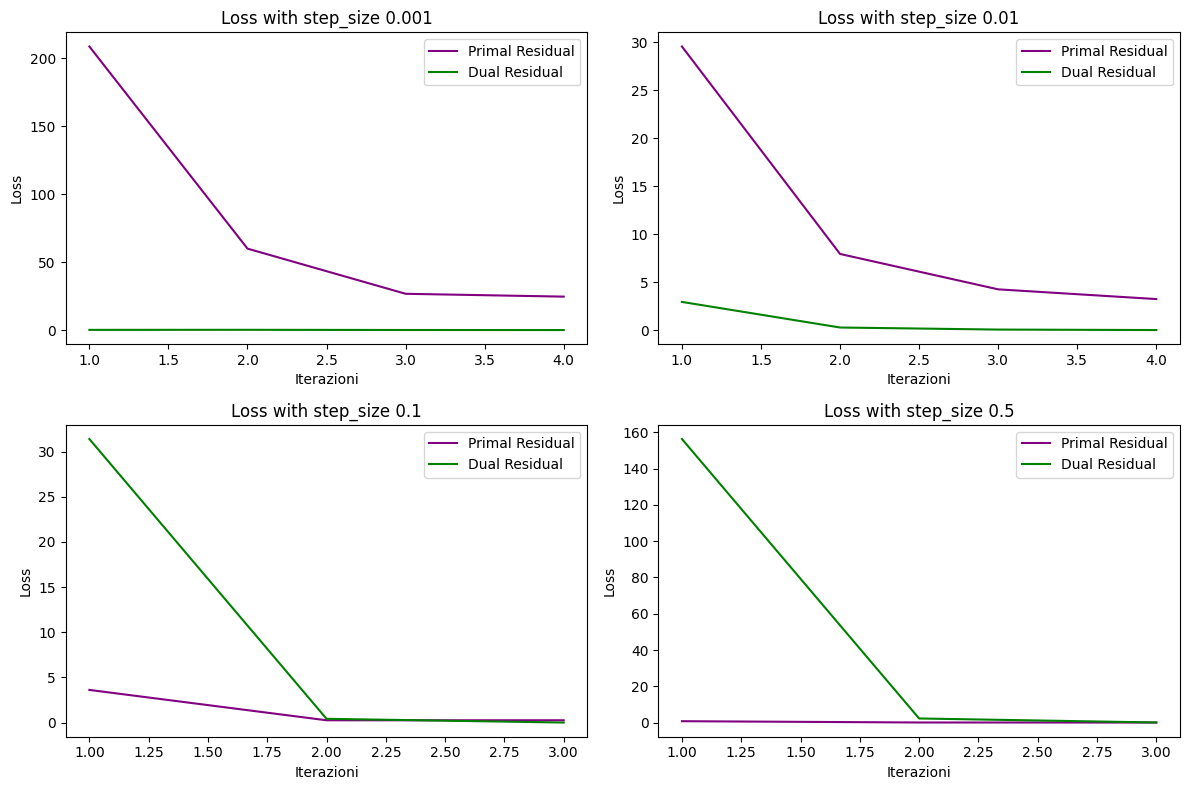

In [99]:
l1_penalty = 0.1
step_sizes = [0.001, 0.01, 0.1, 0.5]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train_2, y_train_2, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with step_size {step_size}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with step_size {step_size}: {iterations_admm}")

    y_pred_admm = lasso_admm.predict(X_test_2)

    r2 = 1 - np.mean((y_test_2 - y_pred_admm) ** 2) / np.var(y_test_2)
    print(f"R^2 with step_size {step_size}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

ADMM time with l1_penalty 0.01: 0.0019996166229248047
ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.8959922374024756
ADMM time with l1_penalty 0.1: 0.0020012855529785156
ADMM iterations with l1_penalty 0.1: 3
R^2 with l1_penalty 0.1: 0.895993401210701
ADMM time with l1_penalty 1: 0.0030028820037841797
ADMM iterations with l1_penalty 1: 4
R^2 with l1_penalty 1: 0.8960048047739202
ADMM time with l1_penalty 10: 0.0030088424682617188
ADMM iterations with l1_penalty 10: 4
R^2 with l1_penalty 10: 0.896070930298968


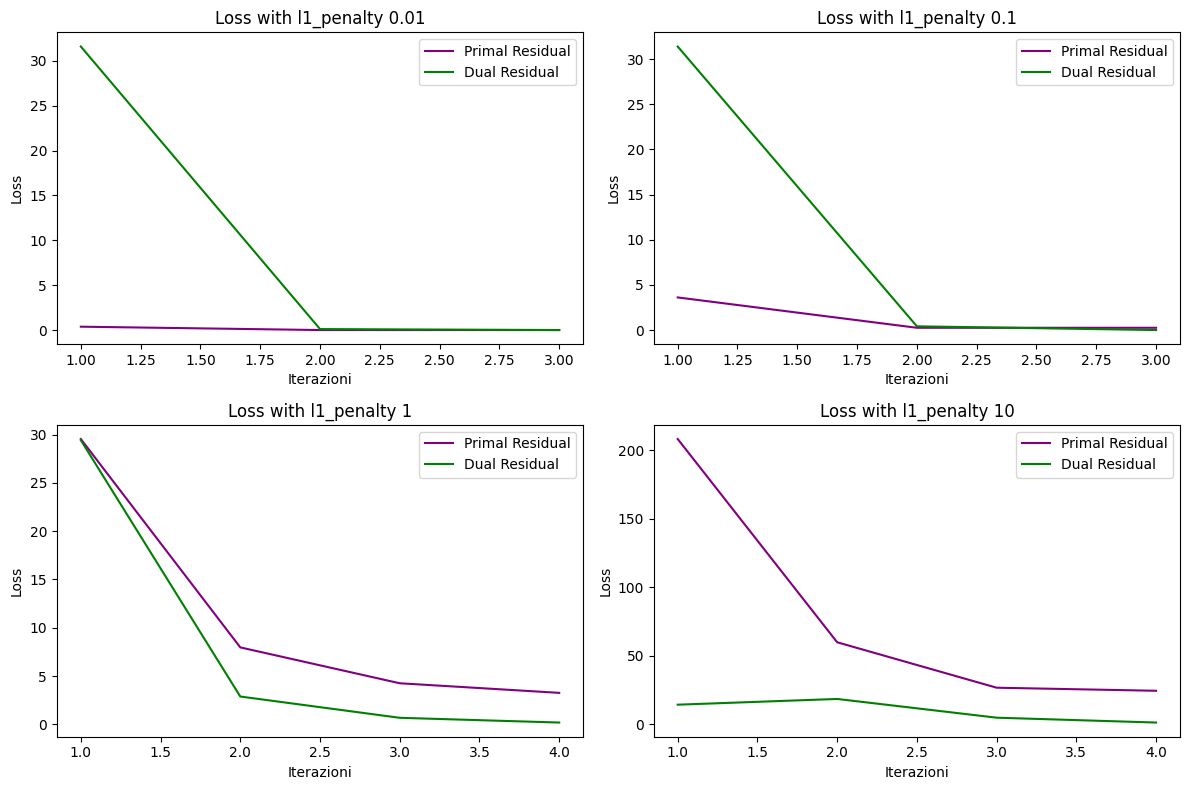

In [100]:
step_size = 0.1
l1_penalties = [0.01, 0.1, 1, 10]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()
    
    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train_2, y_train_2, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with l1_penalty {l1_penalty}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with l1_penalty {l1_penalty}: {iterations_admm}")
    
    y_pred_admm = lasso_admm.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()

plt.show()

### 3.2.3- Lasso Distributed ADMM

Validation of step_size parameter

Distributed ADMM time with step_size 0.001: 0.0049991607666015625
Distributed ADMM iterations with step_size 0.001: 4
R^2 with step_size 0.001: 0.8961125046227685
Distributed ADMM time with step_size 0.01: 0.006001949310302734
Distributed ADMM iterations with step_size 0.01: 4
R^2 with step_size 0.01: 0.8961126318346629
Distributed ADMM time with step_size 0.1: 0.004513263702392578
Distributed ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.8961126456910494
Distributed ADMM time with step_size 0.5: 0.004789829254150391
Distributed ADMM iterations with step_size 0.5: 4
R^2 with step_size 0.5: 0.8961125987272698


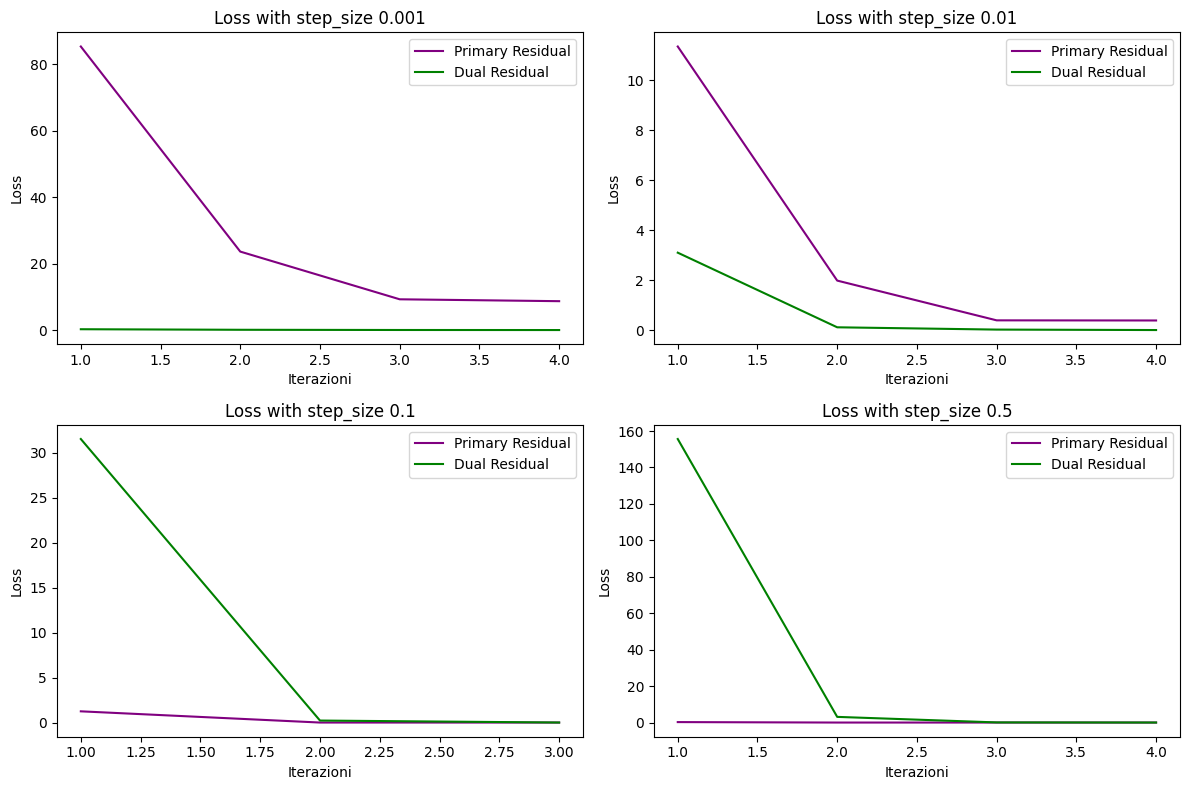

In [101]:
step_sizes = [0.001, 0.01, 0.1, 0.5]
l1_penalty = 0.1
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_2, y_train_2, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with step_size {step_size}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with step_size {step_size}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_distributed_admm)
    print(f"R^2 with step_size {step_size}: {r2}")
    
    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

Distributed ADMM time with l1_penalty 0.01: 0.0021343231201171875
Distributed ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.8961120413606597
Distributed ADMM time with l1_penalty 0.1: 0.0029981136322021484
Distributed ADMM iterations with l1_penalty 0.1: 3
R^2 with l1_penalty 0.1: 0.8961126456910494
Distributed ADMM time with l1_penalty 1: 0.0039021968841552734
Distributed ADMM iterations with l1_penalty 1: 4
R^2 with l1_penalty 1: 0.8961185696085088
Distributed ADMM time with l1_penalty 10: 0.003998517990112305
Distributed ADMM iterations with l1_penalty 10: 4
R^2 with l1_penalty 10: 0.896164391586131


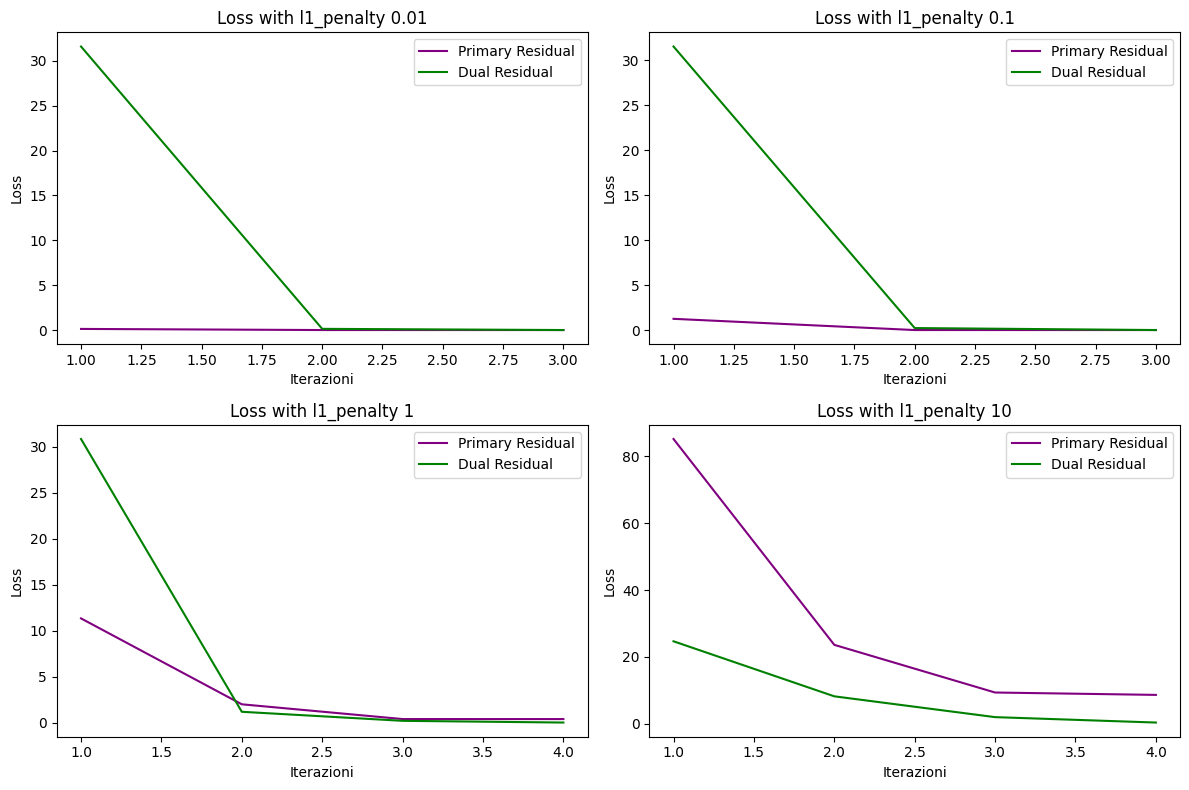

In [102]:
step_size = 0.1
l1_penalties = [0.01, 0.1, 1, 10]
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_2, y_train_2, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with l1_penalty {l1_penalty}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with l1_penalty {l1_penalty}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_distributed_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()
plt.show()

Validation of num_agents parameter

Distributed ADMM time with 3 agents: 0.0020606517791748047
Distributed ADMM iterations with 3 agents: 4
R^2 with 3 agents: 0.8961185696085088
Distributed ADMM time with 5 agents: 0.0035560131072998047
Distributed ADMM iterations with 5 agents: 3
R^2 with 5 agents: 0.8958474837055953
Distributed ADMM time with 10 agents: 0.0032486915588378906
Distributed ADMM iterations with 10 agents: 3
R^2 with 10 agents: 0.8960032932008823
Distributed ADMM time with 20 agents: 0.008063316345214844
Distributed ADMM iterations with 20 agents: 4
R^2 with 20 agents: 0.8961343851074133


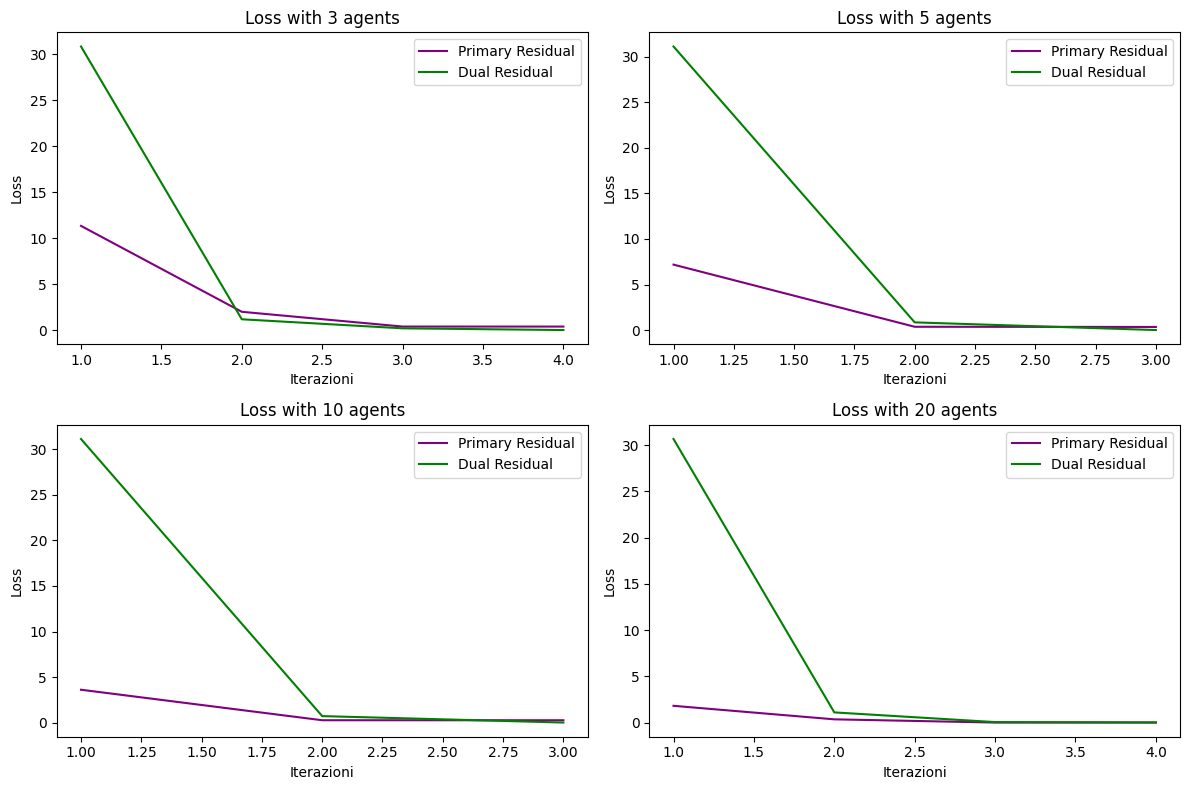

In [103]:
step_size = 0.1
l1_penalty = 1
agents = [3, 5, 10, 20]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, agent in enumerate(agents, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_2, y_train_2, algo="distributed_admm", agents=agent)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with {agent} agents: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with {agent} agents: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_2)

    r2 = r2_score(y_test_2, y_pred_distributed_admm)
    print(f"R^2 with {agent} agents: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with {agent} agents')

plt.tight_layout()
plt.show()

### 3.2.4 Comparison of Lasso versions

Gradient Descent

GD time: 0.21869850158691406
GD iterations: 418
R^2: 0.8958116951135282
MSE: 342.10049861886864
MAE: 14.92101616966976


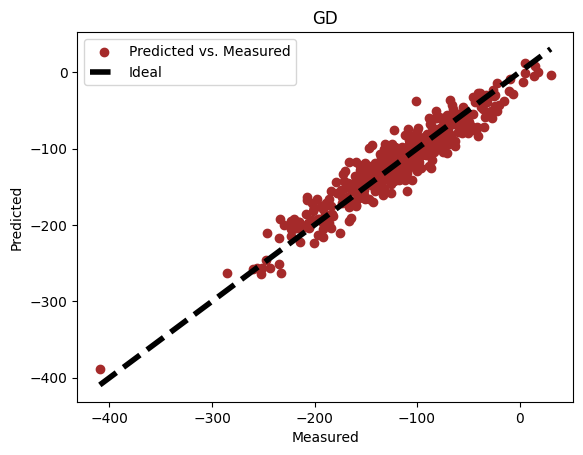

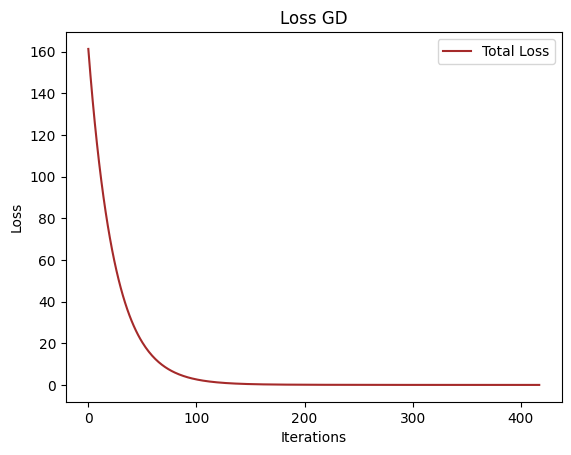

In [104]:
# parameters
step_size = 0.5
l1_penalty = 0.1

# GD
start_time = time.time()
lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_gd.fit(X_train_2, y_train_2, algo="gd")
gd_time = time.time() - start_time
print(f"GD time: {gd_time}")

iterations_gd = lasso_gd.iterations
print(f"GD iterations: {iterations_gd}")

y_pred_gd = lasso_gd.predict(X_test_2)

# metrics
r2_gd = r2_score(y_test_2, y_pred_gd)
print(f"R^2: {r2_gd}")

mse_gd = mean_squared_error(y_test_2, y_pred_gd)
print(f"MSE: {mse_gd}")
mae_gd = mean_absolute_error(y_test_2, y_pred_gd)
print(f"MAE: {mae_gd}")

# plots
prediction_plot(y_test_2, y_pred_gd, "GD")
loss_plot(lasso_gd.J, "Loss GD")

ADMM

ADMM time: 0.004003286361694336
ADMM iterations: 4
R^2: 0.896070930298968
MSE: 341.24930436731506
MAE: 14.913681919868917


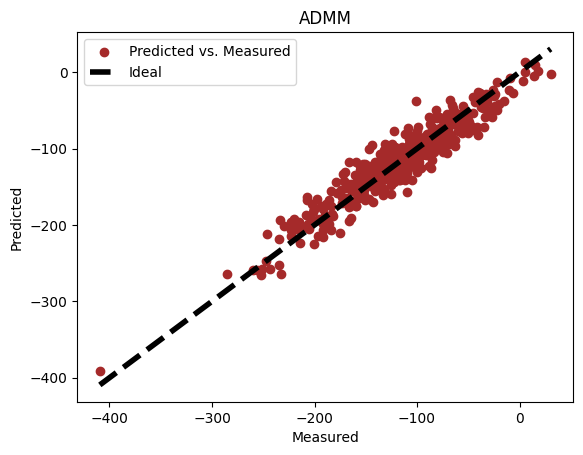

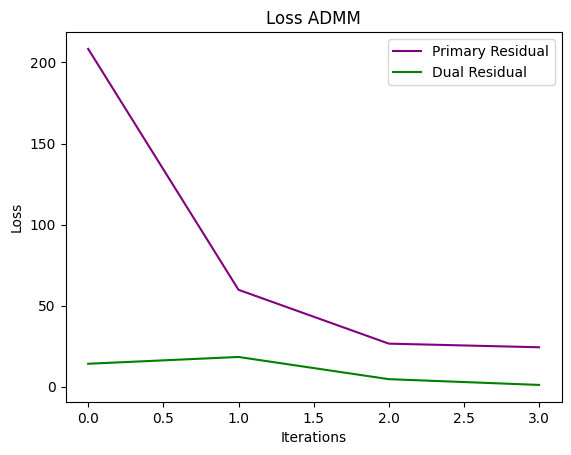

In [105]:
# parameters
step_size = 0.1
l1_penalty = 10

# ADMM
start_time = time.time()
lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train_2, y_train_2, algo="admm")
admm_time = time.time() - start_time
print(f"ADMM time: {admm_time}")

iterations_admm = lasso_admm.iterations
print(f"ADMM iterations: {iterations_admm}")

y_pred_admm = lasso_admm.predict(X_test_2)

# metrics
r2_admm = r2_score(y_test_2, y_pred_admm)
print(f"R^2: {r2_admm}")

mse_admm = mean_squared_error(y_test_2, y_pred_admm)
print(f"MSE: {mse_admm}")
mae_admm = mean_absolute_error(y_test_2, y_pred_admm)
print(f"MAE: {mae_admm}")

# plots
prediction_plot(y_test_2, y_pred_admm, "ADMM")
loss_plot_admm(lasso_admm.J, "Loss ADMM")

Distributed ADMM

Distributed ADMM time: 0.011004209518432617
Distributed ADMM iterations: 4
R^2: 0.8961343851074133
MSE: 341.04095160034615
MAE: 14.909636617103807


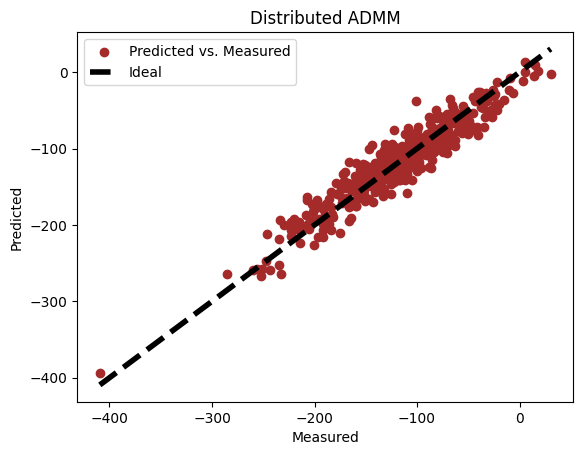

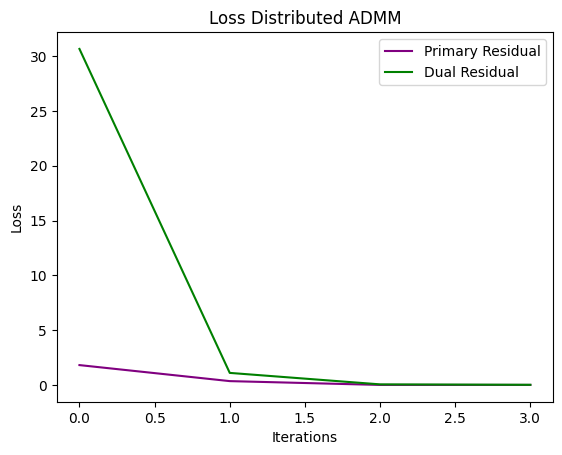

In [106]:
# parameters
step_size = 0.1
l1_penalty = 1
agents = 20

# Distributed ADMM
start_time = time.time()
lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_distributed_admm.fit(X_train_2, y_train_2, algo="distributed_admm", agents=agents)
distributed_admm_time = time.time() - start_time
print(f"Distributed ADMM time: {distributed_admm_time}")

iterations_distributed_admm = lasso_distributed_admm.iterations
print(f"Distributed ADMM iterations: {iterations_distributed_admm}")

y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_2)

# metrics
r2_distributed_admm = r2_score(y_test_2, y_pred_distributed_admm)
print(f"R^2: {r2_distributed_admm}")

mse_distributed_admm = mean_squared_error(y_test_2, y_pred_distributed_admm)
print(f"MSE: {mse_distributed_admm}")
mae_distributed_admm = mean_absolute_error(y_test_2, y_pred_distributed_admm)
print(f"MAE: {mae_distributed_admm}")

# plots
prediction_plot(y_test_2, y_pred_distributed_admm, "Distributed ADMM")
loss_plot_admm(lasso_distributed_admm.J, "Loss Distributed ADMM")

# 4- Test on real dataset

## 4.1- Dataset import

An already pre-processed and cleaned dataset is imported

In [108]:
parent_folder = os.path.dirname(os.getcwd())
data_folder = "Data"
dataset_name = "cleaned_concrete_data.csv"
dataset_path = os.path.join(parent_folder, data_folder, dataset_name)

df_real = pd.read_csv(dataset_path)

In [109]:
print(df_real.head())
print(df_real.shape)

   cement    slag     ash   water  superplasticizer  coarse    fine  age  \
0  359.00   19.00  141.00  154.00             10.91   942.0  801.00    3   
1  250.20  166.80    0.00  203.50              0.00   977.6  694.10    7   
2  168.88   42.22  124.25  158.33             10.83  1080.8  796.15   56   
3  200.00    0.00    0.00  180.00              0.00  1125.0  845.00    7   
4  540.00    0.00    0.00  173.00              0.00  1125.0  613.00   28   

    strength  
0  25.116626  
1  19.350144  
2  39.148447  
3   7.839342  
4  67.306647  
(1005, 9)


Division of the dataset into train set and test set

In [110]:
X_real = df_real.drop('strength', axis=1).values
y_real = df_real['strength'].values

X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=0.2, random_state=42)

Data normalisation

In [111]:
scaler = MinMaxScaler()
X_train_real = scaler.fit_transform(X_train_real)
X_test_real = scaler.transform(X_test_real)

In [112]:
# parameters
step_size = 0.01
l1_penalty = 0.1
max_iterations = 100000
tolerance = 1e-3

## 4.2- Training and testing the model on the dataset evaluating the impact of the choice of parameters

### 4.2.1- Lasso Gradient Descent

Validation of step_size parameter

In [ ]:
step_sizes = [0.001, 0.01, 0.1, 0.5]

for step_size in step_sizes:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train_real, y_train_real, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with step_size {step_size}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with step_size {step_size}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_gd)
    print(f"R^2 with step_size {step_size}: {r2}")

GD time with step_size 0.001: 0.9506847858428955
GD iterations with step_size 0.001: 19652
R^2 with step_size 0.001: 0.5566210274607339
GD time with step_size 0.01: 0.4954705238342285
GD iterations with step_size 0.01: 10922
R^2 with step_size 0.01: 0.6155771242194971
GD time with step_size 0.1: 0.1329665184020996
GD iterations with step_size 0.1: 2594
R^2 with step_size 0.1: 0.6209820576587446
GD time with step_size 0.5: 0.039034128189086914
GD iterations with step_size 0.5: 727
R^2 with step_size 0.5: 0.6213591700312899


Validation of l1_penalty parameter

In [113]:
step_size = 0.5
l1_penalties = [0.01, 0.1, 1, 10]

for l1_penalty in l1_penalties:
    start_time = time.time()
    
    lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_gd.fit(X_train_real, y_train_real, algo="gd")
    gd_time = time.time() - start_time
    print(f"GD time with l1_penalty {l1_penalty}: {gd_time}")

    iterations_gd = lasso_gd.iterations
    print(f"GD iterations with l1_penalty {l1_penalty}: {iterations_gd}")
    
    y_pred_gd = lasso_gd.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_gd)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

GD time with l1_penalty 0.01: 0.060971736907958984
GD iterations with l1_penalty 0.01: 715
R^2 with l1_penalty 0.01: 0.5782599042809814
GD time with l1_penalty 0.1: 0.05312848091125488
GD iterations with l1_penalty 0.1: 715
R^2 with l1_penalty 0.1: 0.5782636926612755
GD time with l1_penalty 1: 0.058385372161865234
GD iterations with l1_penalty 1: 715
R^2 with l1_penalty 1: 0.5783013390486571
GD time with l1_penalty 10: 0.05356788635253906
GD iterations with l1_penalty 10: 719
R^2 with l1_penalty 10: 0.5785792660678742


### 4.2.2 Lasso ADMM

Validation of step_size parameter

ADMM time with step_size 0.001: 0.001538991928100586
ADMM iterations with step_size 0.001: 12
R^2 with step_size 0.001: 0.5784185938821937
ADMM time with step_size 0.01: 0.0010051727294921875
ADMM iterations with step_size 0.01: 4
R^2 with step_size 0.01: 0.5784171362791407
ADMM time with step_size 0.1: 0.0009992122650146484
ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.5784173052425519
ADMM time with step_size 0.5: 0.0009520053863525391
ADMM iterations with step_size 0.5: 4
R^2 with step_size 0.5: 0.5784171744812676


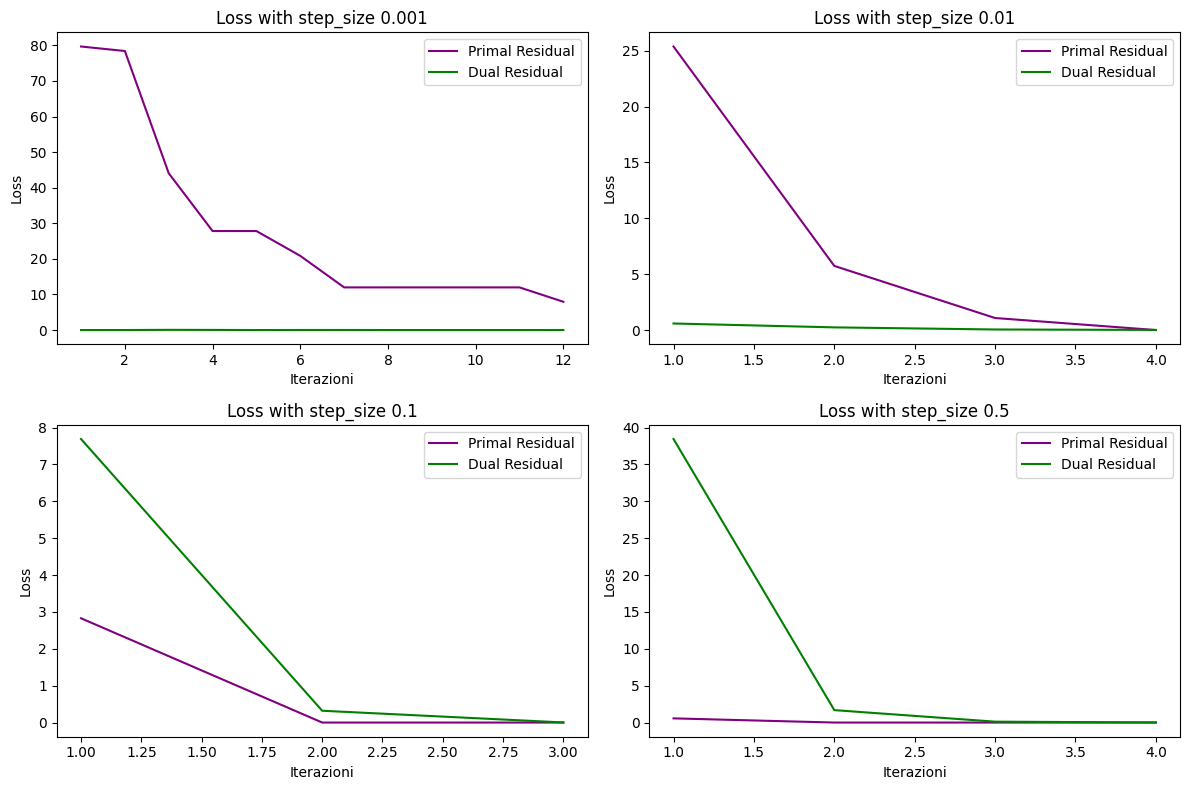

In [114]:
l1_penalty = 0.1
step_sizes = [0.001, 0.01, 0.1, 0.5]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train_real, y_train_real, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with step_size {step_size}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with step_size {step_size}: {iterations_admm}")

    y_pred_admm = lasso_admm.predict(X_test_real)

    r2 = 1 - np.mean((y_test_real - y_pred_admm) ** 2) / np.var(y_test_real)
    print(f"R^2 with step_size {step_size}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

ADMM time with l1_penalty 0.01: 0.0009057521820068359
ADMM iterations with l1_penalty 0.01: 3
R^2 with l1_penalty 0.01: 0.5784217731687602
ADMM time with l1_penalty 0.1: 0.0010008811950683594
ADMM iterations with l1_penalty 0.1: 3
R^2 with l1_penalty 0.1: 0.578417305242552
ADMM time with l1_penalty 1: 0.000997781753540039
ADMM iterations with l1_penalty 1: 4
R^2 with l1_penalty 1: 0.5783697686688758
ADMM time with l1_penalty 10: 0.0018434524536132812
ADMM iterations with l1_penalty 10: 12
R^2 with l1_penalty 10: 0.5779445082605728


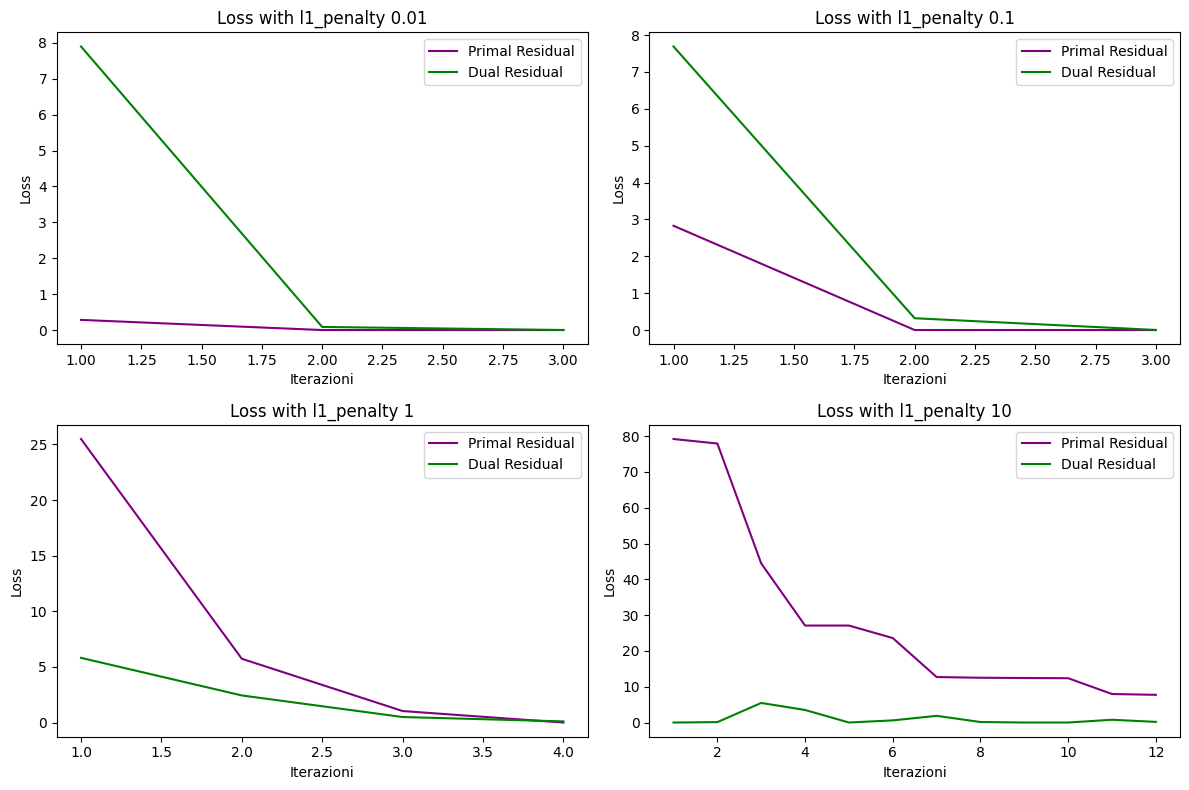

In [115]:
step_size = 0.1
l1_penalties = [0.01, 0.1, 1, 10]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()
    
    lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_admm.fit(X_train_real, y_train_real, algo="admm")
    admm_time = time.time() - start_time
    print(f"ADMM time with l1_penalty {l1_penalty}: {admm_time}")

    iterations_admm = lasso_admm.iterations
    print(f"ADMM iterations with l1_penalty {l1_penalty}: {iterations_admm}")
    
    y_pred_admm = lasso_admm.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    while i > axs.size:
        axs = np.append(axs, plt.subplots(2, 2, figsize=(12, 8))[1], axis=0)

    row = (i - 1) // 2
    col = (i - 1) % 2

    loss_plot_admm_val(axs[row, col], lasso_admm.J, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()

plt.show()

### 4.2.3- Lasso Distributed ADMM

Validation of step_size parameter

Distributed ADMM time with step_size 0.001: 0.0029973983764648438
Distributed ADMM iterations with step_size 0.001: 4
R^2 with step_size 0.001: 0.5731848544602733
Distributed ADMM time with step_size 0.01: 0.003058195114135742
Distributed ADMM iterations with step_size 0.01: 3
R^2 with step_size 0.01: 0.5731979533513698
Distributed ADMM time with step_size 0.1: 0.0021772384643554688
Distributed ADMM iterations with step_size 0.1: 3
R^2 with step_size 0.1: 0.57334025899843
Distributed ADMM time with step_size 0.5: 0.02418804168701172
Distributed ADMM iterations with step_size 0.5: 34
R^2 with step_size 0.5: 0.5771837562055868


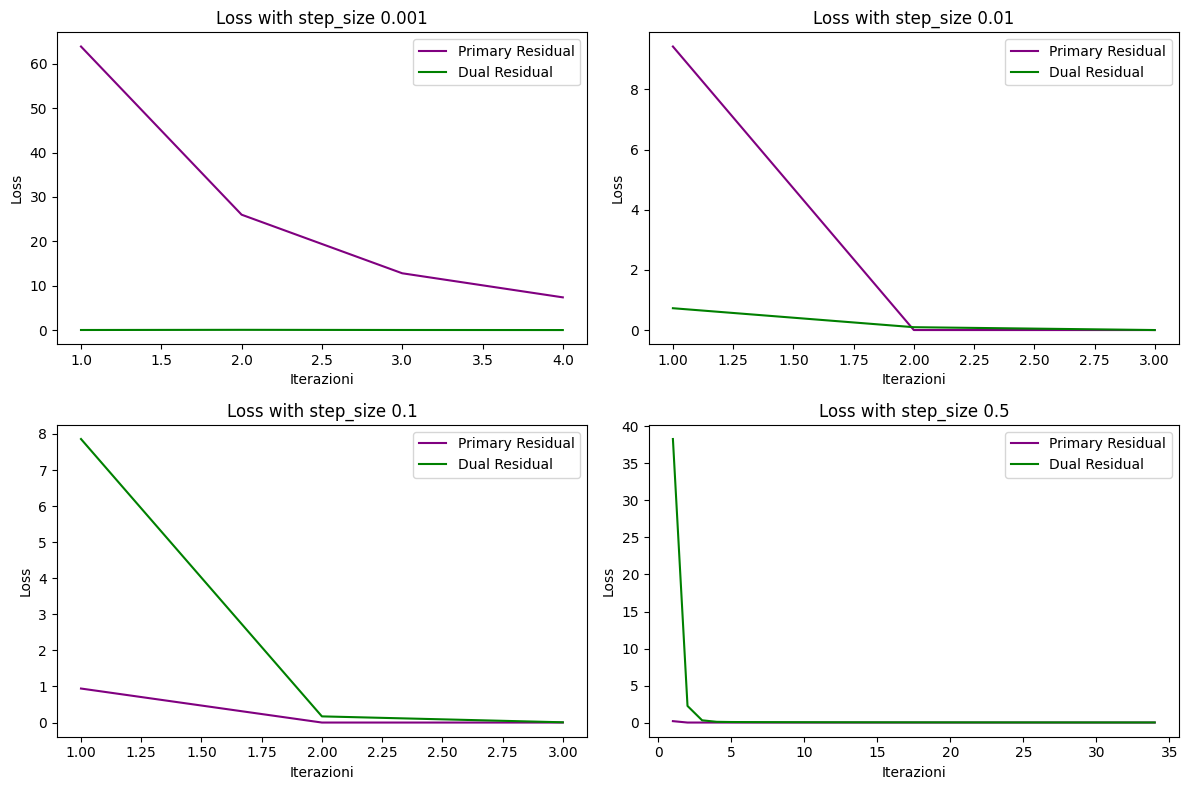

In [116]:
step_sizes = [0.001, 0.01, 0.1, 0.5]
l1_penalty = 0.1
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, step_size in enumerate(step_sizes, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_real, y_train_real, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with step_size {step_size}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with step_size {step_size}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_distributed_admm)
    print(f"R^2 with step_size {step_size}: {r2}")
    
    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with step_size {step_size}')

plt.tight_layout()

plt.show()

Validation of l1_penalty parameter

Distributed ADMM time with l1_penalty 0.01: 0.0942380428314209
Distributed ADMM iterations with l1_penalty 0.01: 64
R^2 with l1_penalty 0.01: 0.5780048562501336
Distributed ADMM time with l1_penalty 0.1: 0.024506092071533203
Distributed ADMM iterations with l1_penalty 0.1: 34
R^2 with l1_penalty 0.1: 0.5771837562055868
Distributed ADMM time with l1_penalty 1: 0.003001689910888672
Distributed ADMM iterations with l1_penalty 1: 5
R^2 with l1_penalty 1: 0.5742793278052368
Distributed ADMM time with l1_penalty 10: 0.003116130828857422
Distributed ADMM iterations with l1_penalty 10: 4
R^2 with l1_penalty 10: 0.5738993965858458


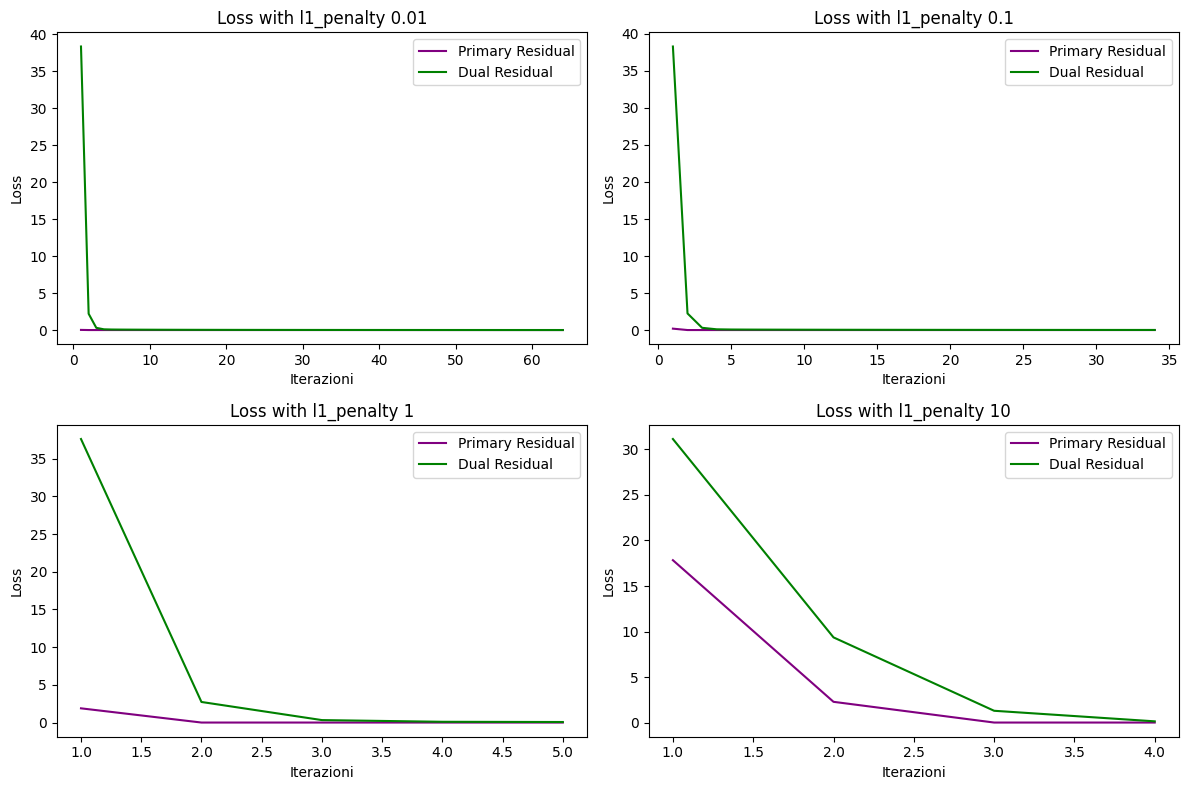

In [117]:
step_size = 0.5
l1_penalties = [0.01, 0.1, 1, 10]
agents = 3

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, l1_penalty in enumerate(l1_penalties, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_real, y_train_real, algo="distributed_admm", agents=agents)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with l1_penalty {l1_penalty}: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with l1_penalty {l1_penalty}: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_distributed_admm)
    print(f"R^2 with l1_penalty {l1_penalty}: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with l1_penalty {l1_penalty}')

plt.tight_layout()

plt.show()

Validation of num_agents parameters

Distributed ADMM time with 3 agents: 0.035111188888549805
Distributed ADMM iterations with 3 agents: 64
R^2 with 3 agents: 0.5780048562501336
Distributed ADMM time with 5 agents: 0.021688461303710938
Distributed ADMM iterations with 5 agents: 42
R^2 with 5 agents: 0.5787464712625618
Distributed ADMM time with 10 agents: 0.023244619369506836
Distributed ADMM iterations with 10 agents: 33
R^2 with 10 agents: 0.578624638289561
Distributed ADMM time with 20 agents: 0.07311296463012695
Distributed ADMM iterations with 20 agents: 67
R^2 with 20 agents: 0.5781017870352722


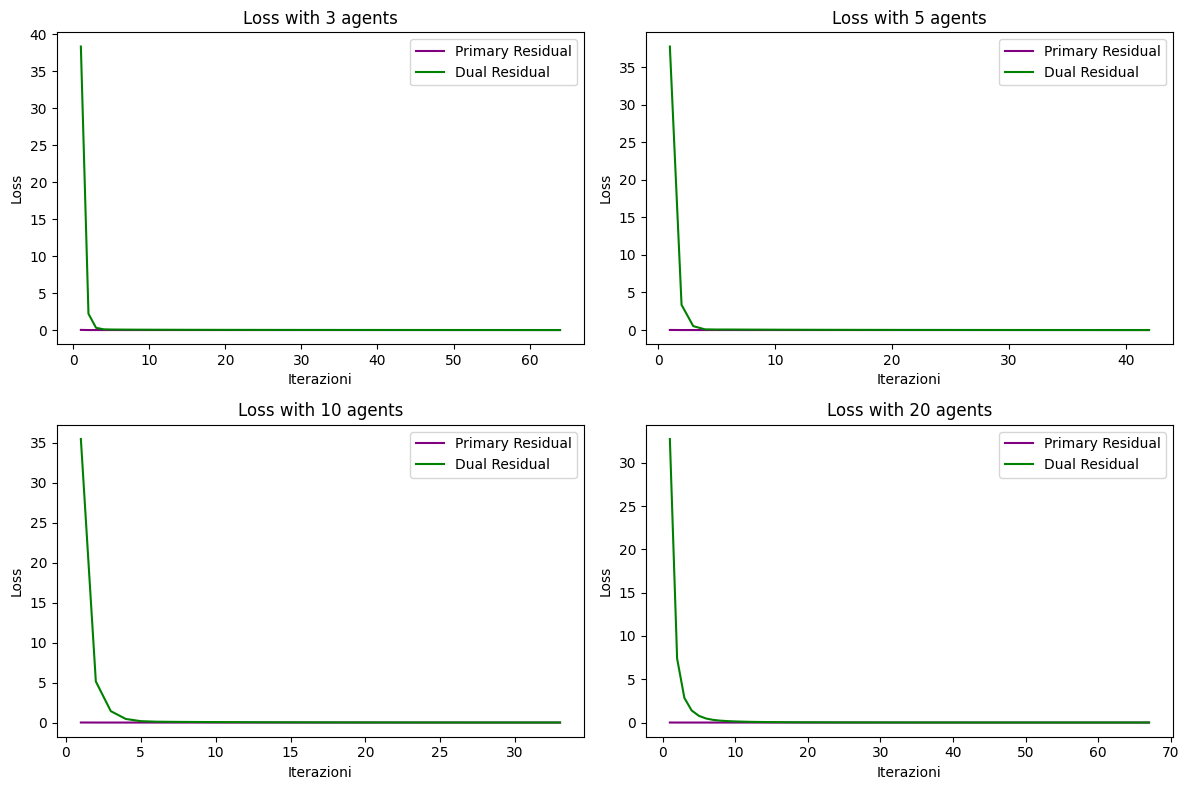

In [118]:
step_size = 0.5
l1_penalty = 0.01
agents = [3, 5, 10, 20]

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, agent in enumerate(agents, 1):
    start_time = time.time()

    lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
    lasso_distributed_admm.fit(X_train_real, y_train_real, algo="distributed_admm", agents=agent)
    distributed_admm_time = time.time() - start_time
    print(f"Distributed ADMM time with {agent} agents: {distributed_admm_time}")

    iterations_distributed_admm = lasso_distributed_admm.iterations
    print(f"Distributed ADMM iterations with {agent} agents: {iterations_distributed_admm}")

    y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_real)

    r2 = r2_score(y_test_real, y_pred_distributed_admm)
    print(f"R^2 with {agent} agents: {r2}")

    row = (i - 1) // 2
    col = (i - 1) % 2
    
    loss_plot_distributed_admm_val(axs[row, col], lasso_distributed_admm, f'Loss with {agent} agents')

plt.tight_layout()

plt.show()

### 4.2.2 Comparison of Lasso versions

Gradient Descent

GD time: 0.08395528793334961
GD iterations: 719
R^2: 0.5785792660678742
MSE: 115.54758089902886
MAE: 8.449060398644523


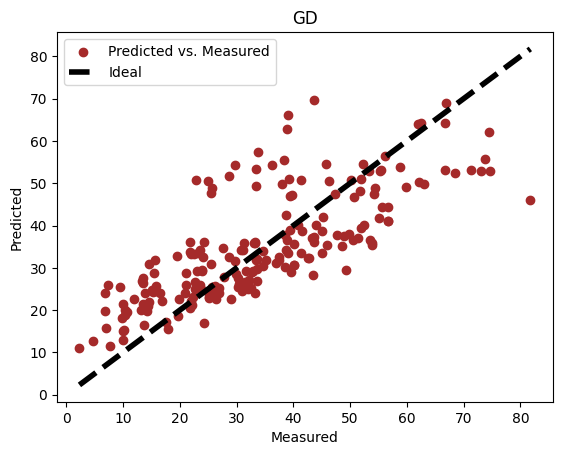

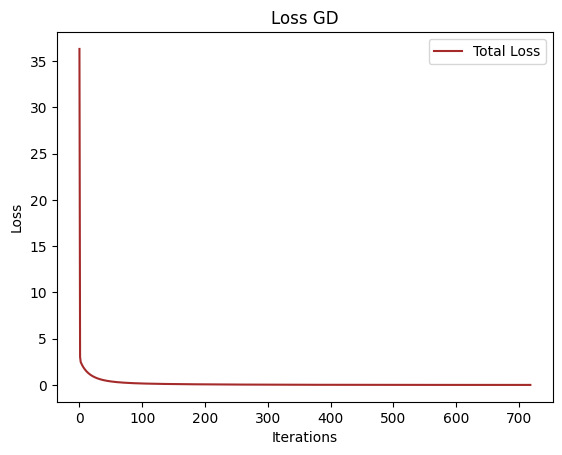

In [119]:
# parameters
step_size = 0.5
l1_penalty = 10

# GD
start_time = time.time()
lasso_gd = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_gd.fit(X_train_real, y_train_real, algo="gd")
gd_time = time.time() - start_time
print(f"GD time: {gd_time}")

iterations_gd = lasso_gd.iterations
print(f"GD iterations: {iterations_gd}")

y_pred_gd = lasso_gd.predict(X_test_real)

# metrics
r2_gd = r2_score(y_test_real, y_pred_gd)
print(f"R^2: {r2_gd}")

mse_gd = mean_squared_error(y_test_real, y_pred_gd)
print(f"MSE: {mse_gd}")
mae_gd = mean_absolute_error(y_test_real, y_pred_gd)
print(f"MAE: {mae_gd}")

# plots
prediction_plot(y_test_real, y_pred_gd, "GD")
loss_plot(lasso_gd.J, "Loss GD")

ADMM

ADMM time: 0.0026273727416992188
ADMM iterations: 3
R^2: 0.578417305242552
MSE: 115.5919882574229
MAE: 8.442453581544651


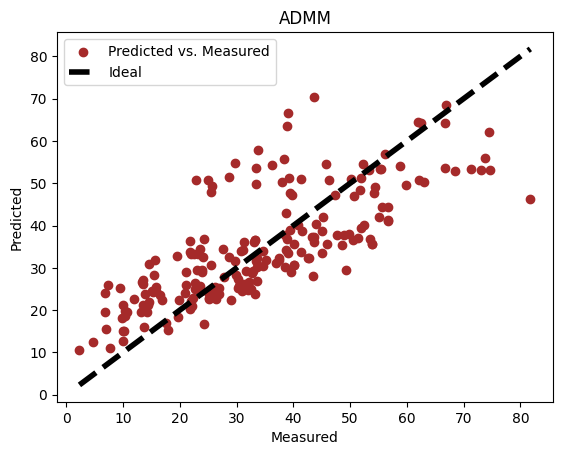

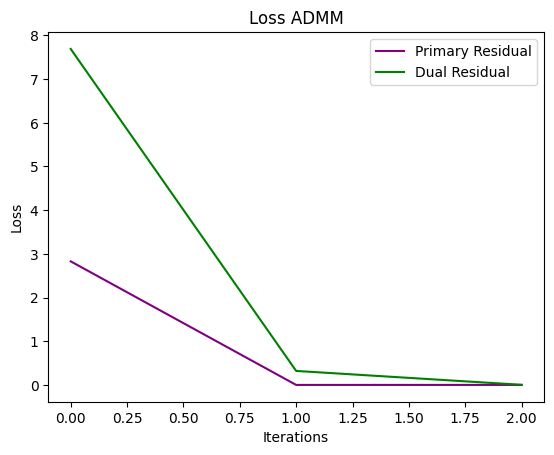

In [120]:
# parameters
step_size = 0.1
l1_penalty = 0.1

# ADMM
start_time = time.time()
lasso_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_admm.fit(X_train_real, y_train_real, algo="admm")
admm_time = time.time() - start_time
print(f"ADMM time: {admm_time}")

iterations_admm = lasso_admm.iterations
print(f"ADMM iterations: {iterations_admm}")

y_pred_admm = lasso_admm.predict(X_test_real)

# metrics
r2_admm = r2_score(y_test_real, y_pred_admm)
print(f"R^2: {r2_admm}")

mse_admm = mean_squared_error(y_test_real, y_pred_admm)
print(f"MSE: {mse_admm}")
mae_admm = mean_absolute_error(y_test_real, y_pred_admm)
print(f"MAE: {mae_admm}")

# plots
prediction_plot(y_test_real, y_pred_admm, "ADMM")
loss_plot_admm(lasso_admm.J, "Loss ADMM")

Distributed ADMM

Distributed ADMM time: 0.05601048469543457
Distributed ADMM iterations: 42
R^2: 0.5787464712625618
MSE: 115.50173560902704
MAE: 8.441440746510926


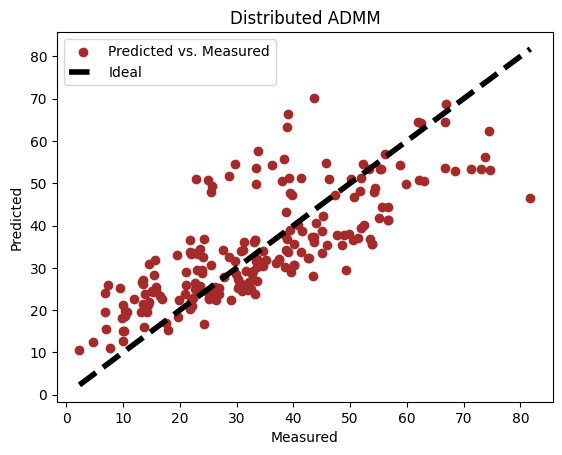

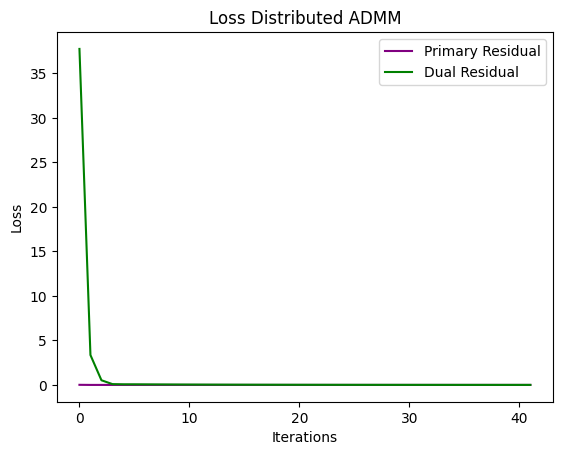

In [121]:
# parameters
step_size = 0.5
l1_penalty = 0.01
agents = 5

# Distributed ADMM
start_time = time.time()
lasso_distributed_admm = LassoReg(step_size, max_iterations, l1_penalty, tolerance)
lasso_distributed_admm.fit(X_train_real, y_train_real, algo="distributed_admm", agents=agents)
distributed_admm_time = time.time() - start_time
print(f"Distributed ADMM time: {distributed_admm_time}")

iterations_distributed_admm = lasso_distributed_admm.iterations
print(f"Distributed ADMM iterations: {iterations_distributed_admm}")

y_pred_distributed_admm = lasso_distributed_admm.predict(X_test_real)

# metrics
r2_distributed_admm = r2_score(y_test_real, y_pred_distributed_admm)
print(f"R^2: {r2_distributed_admm}")

mse_distributed_admm = mean_squared_error(y_test_real, y_pred_distributed_admm)
print(f"MSE: {mse_distributed_admm}")
mae_distributed_admm = mean_absolute_error(y_test_real, y_pred_distributed_admm)
print(f"MAE: {mae_distributed_admm}")

# plots
prediction_plot(y_test_real, y_pred_distributed_admm, "Distributed ADMM")
loss_plot_admm(lasso_distributed_admm.J, "Loss Distributed ADMM")